[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/broad-1/quickstarters/basic-eda/basic-EDA.ipynb)

# Broad Institute: Autoimmune Disease Machine Learning Challenge

![Cover](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-1/cover.jpg)

## Crunch 1 – Quickstarter

## The Problem

Autoimmune diseases arise when the immune system mistakenly targets healthy cells. Affecting 50M people in the U.S., with rising global cases, Inflammatory Bowel Disease (IBD) is one of the most prevalent forms. IBD involves a breakdown in the gut barrier, triggering the immune system to attack proteins erroneously recognized as foreign, leading to persistent inflammation. This cycle of flares and remission increases the risk of colorectal cancer (up to two-fold). Although modern treatments have improved survival, IBD remains challenging to diagnose and treat due to its complex symptoms and multifactorial nature.
Pathologists rely on gut tissue images to diagnose and treat IBD, guiding decisions on the most suitable drug treatments and predicting cancer risk. These tissue images, combined with recent advances in genomics, offer a valuable dataset for machine learning models to revolutionize IBD diagnosis and treatment.

## The Solution

In Crunch 1, you will train an algorithm to predict spatial transcriptomics data (gene expression in each cell). In other words predict the gene expression (Y) in cells from specific tissue patches based on the H&E images (X) and surrounding spatial transcriptomics data.

#### X (Input):

- **HE_registered**: The registered H&E image, aligned to the Xenium spatial transcriptomics coordinate system. This is the recommended file to use as it is already aligned with the spatial transcriptomics data.

- **HE_original**: The original H&E image in its native pixel coordinates, before alignment. If you prefer to handle alignment yourself, you can use this, but it may require additional processing.

#### Y (Output):

- **anucleus**: This file contains the aggregated gene expression data for each nucleus. It is log1p-normalized and stores the gene expression profiles for 460 genes per nucleus. This is the primary target (Y) for your model.

- **transcripts**: This file contains the spatial locations and individual gene expression data for each transcript in the tissue, linked to specific nuclei. It provides the raw gene expression information before aggregation.

# Preliminary Setup Step

In [ ]:
%pip install --upgrade crunch-cli

In [ ]:
# Registering to this Crunch

# Step 1:
# Create an account here: https://hub.crunchdao.com/auth/register

# Step 2:
# Get your set token here: https://hub.crunchdao.com/competitions/broad-1/submit/via/notebook
!crunch setup --notebook broad hello --token aaaabbbbccccddddeeeeffff

# Data Preparation

## Imports

In [11]:
"""
This is a basic example of what you need to do to enter the competition.
The code will not have access to the internet (or any socket related operation).
"""
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
import spatialdata_plot
import spatialdata as sd
import scanpy as sc

In [113]:
def square(i):
    
    return int(i)*int(i)
names=['1','2']
dict={i: square(i) for i in names}
dict['2']


4

In [28]:
from PIL import Image 
import torchvision.transforms as transforms
import torch
trans=transforms.Compose([transforms.ColorJitter(0.5, 0.5, 0.5), transforms.ToTensor()])
img= torch.Tensor(np.array(Image.open('E:/projects/Gene_expression/data/her2st/data/ST-imgs/A/A1/9769_C1_HE_small.jpg')))
print(img.size(),img.permute(1, 0, 2).size())
img= trans( img
)
print(img.size(),img.permute(1, 0, 2).size())
del img


torch.Size([7435, 6954, 3]) torch.Size([6954, 7435, 3])


TypeError: Input image tensor permitted channel values are [1, 3], but found 7435

## The datasets

In [4]:
# del sdata

sdata = sd.read_zarr(f"../data/DC5.zarr")
sdata

E:\conda\envs\thitogene\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: C:\DATA\Crunch\data\DC5.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 18000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 18000, 22000)
└── Tables
      ├── 'anucleus': AnnData (140368, 460)
      └── 'cell_id-group': AnnData (171019, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

In [34]:
train=sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].values
train.sort()


In [35]:
train

array([     6,     12,     14, ..., 224297, 224301, 224325], dtype=uint32)

In [10]:
from skimage.measure import regionprops

regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

train_length= len( sdata['anucleus'].layers['counts'])



NameError: name 'random' is not defined

In [17]:
partial_train_length=int(train_length*0.9)
split_train_binary=[1] * partial_train_length + [0] * (train_length-partial_train_length)
# split_train_binary=[1] * 62000 + [0] * (train_length-62000)
random.shuffle(split_train_binary)
print(len(split_train_binary),train_length,int(train_length*0.9))

center_list=[]
cell_id_list=[]
# Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)
i=0
for props in tqdm(regions):
    cell_id= props.label
    
    if i!=cell_id:
        print(i,cell_id)
    i+=1
    if cell_id >= len( sdata['anucleus'].layers['counts']):
        continue
    
    if split_train_binary[cell_id] ==0:
        continue
    
    
    centroid = props.centroid
    center_list.append([int(centroid[0]), int(centroid[1])])
    cell_id_list.append(int(cell_id))
print(len(center_list))

140368 140368 126331


  0%|▋                                                                                                                                  | 834/171019 [00:00<00:20, 8267.00it/s]

0 6
1 12
2 14
3 23
4 37
5 39
6 43
7 67
8 75
9 76
10 80
11 81
12 82
13 88
14 104
15 107
16 109
17 115
18 130
19 133
20 140
21 142
22 149
23 158
24 200
25 201
26 213
27 253
28 323
29 358
30 362
31 370
32 375
33 377
34 381
35 404
36 523
37 1874
38 2969
39 2970
40 2971
41 2972
42 2973
43 2974
44 2975
45 2976
46 2977
47 2978
48 2979
49 2980
50 2981
51 2982
52 2983
53 2984
54 2985
55 2986
56 2987
57 2988
58 2989
59 2990
60 2991
61 2992
62 2993
63 2994
64 2995
65 2996
66 2997
67 2998
68 2999
69 3000
70 3001
71 3002
72 3003
73 3004
74 3005
75 3007
76 3008
77 3009
78 3011
79 3012
80 3013
81 3014
82 3015
83 3016
84 3017
85 3018
86 3019
87 3020
88 3021
89 3022
90 3023
91 3025
92 3028
93 3029
94 3030
95 3031
96 3032
97 3033
98 3034
99 3035
100 3036
101 3037
102 3038
103 3039
104 3040
105 3041
106 3042
107 3043
108 3044
109 3045
110 3046
111 3047
112 3048
113 3049
114 3050
115 3051
116 3052
117 3053
118 3054
119 3055
120 3056
121 3057
122 3058
123 3059
124 3060
125 3061
126 3062
127 3063
128 3064
1

  1%|█▋                                                                                                                               | 2180/171019 [00:00<00:15, 11255.89it/s]

2180 5277
2181 5278
2182 5279
2183 5280
2184 5281
2185 5282
2186 5284
2187 5285
2188 5286
2189 5287
2190 5288
2191 5289
2192 5290
2193 5291
2194 5292
2195 5293
2196 5294
2197 5295
2198 5296
2199 5298
2200 5299
2201 5300
2202 5301
2203 5302
2204 5303
2205 5304
2206 5305
2207 5306
2208 5307
2209 5308
2210 5309
2211 5310
2212 5311
2213 5312
2214 5313
2215 5314
2216 5315
2217 5316
2218 5317
2219 5318
2220 5319
2221 5320
2222 5321
2223 5322
2224 5323
2225 5324
2226 5325
2227 5326
2228 5327
2229 5328
2230 5329
2231 5331
2232 5332
2233 5333
2234 5334
2235 5335
2236 5336
2237 5337
2238 5338
2239 5339
2240 5341
2241 5342
2242 5343
2243 5344
2244 5345
2245 5347
2246 5348
2247 5350
2248 5351
2249 5352
2250 5353
2251 5354
2252 5355
2253 5356
2254 5357
2255 5358
2256 5359
2257 5360
2258 5361
2259 5362
2260 5363
2261 5364
2262 5365
2263 5366
2264 5367
2265 5368
2266 5369
2267 5370
2268 5371
2269 5372
2270 5373
2271 5374
2272 5375
2273 5376
2274 5378
2275 5379
2276 5380
2277 5381
2278 5382
2279 5383


  2%|██▌                                                                                                                              | 3324/171019 [00:00<00:14, 11334.92it/s]

2845 6184
2846 6185
2847 6186
2848 6187
2849 6188
2850 6189
2851 6190
2852 6191
2853 6193
2854 6195
2855 6196
2856 6197
2857 6198
2858 6200
2859 6201
2860 6202
2861 6203
2862 6204
2863 6205
2864 6206
2865 6207
2866 6208
2867 6210
2868 6212
2869 6213
2870 6214
2871 6215
2872 6216
2873 6217
2874 6218
2875 6219
2876 6220
2877 6221
2878 6222
2879 6223
2880 6224
2881 6225
2882 6226
2883 6227
2884 6228
2885 6229
2886 6230
2887 6231
2888 6232
2889 6233
2890 6235
2891 6236
2892 6237
2893 6238
2894 6239
2895 6240
2896 6242
2897 6243
2898 6244
2899 6245
2900 6246
2901 6247
2902 6248
2903 6249
2904 6250
2905 6251
2906 6252
2907 6253
2908 6254
2909 6255
2910 6256
2911 6257
2912 6258
2913 6259
2914 6260
2915 6261
2916 6262
2917 6263
2918 6264
2919 6265
2920 6266
2921 6267
2922 6268
2923 6269
2924 6270
2925 6272
2926 6273
2927 6274
2928 6276
2929 6277
2930 6278
2931 6279
2932 6280
2933 6281
2934 6282
2935 6283
2936 6284
2937 6285
2938 6286
2939 6287
2940 6288
2941 6289
2942 6290
2943 6292
2944 6293


  3%|███▎                                                                                                                             | 4458/171019 [00:00<00:14, 11302.48it/s]

4417 8374
4418 8375
4419 8378
4420 8379
4421 8380
4422 8381
4423 8382
4424 8383
4425 8384
4426 8386
4427 8387
4428 8388
4429 8389
4430 8390
4431 8391
4432 8392
4433 8393
4434 8394
4435 8395
4436 8396
4437 8397
4438 8399
4439 8400
4440 8401
4441 8402
4442 8403
4443 8404
4444 8405
4445 8406
4446 8407
4447 8408
4448 8409
4449 8410
4450 8411
4451 8412
4452 8413
4453 8414
4454 8415
4455 8416
4456 8417
4457 8418
4458 8419
4459 8420
4460 8421
4461 8423
4462 8426
4463 8427
4464 8428
4465 8429
4466 8430
4467 8431
4468 8432
4469 8433
4470 8434
4471 8435
4472 8436
4473 8438
4474 8439
4475 8440
4476 8441
4477 8442
4478 8443
4479 8444
4480 8445
4481 8446
4482 8447
4483 8448
4484 8449
4485 8450
4486 8452
4487 8453
4488 8454
4489 8455
4490 8456
4491 8457
4492 8458
4493 8459
4494 8460
4495 8461
4496 8462
4497 8463
4498 8465
4499 8466
4500 8467
4501 8468
4502 8469
4503 8470
4504 8472
4505 8473
4506 8474
4507 8476
4508 8477
4509 8478
4510 8479
4511 8480
4512 8481
4513 8482
4514 8483
4515 8484
4516 8485


  3%|████▎                                                                                                                            | 5709/171019 [00:00<00:14, 11734.96it/s]

5320 9481
5321 9482
5322 9483
5323 9485
5324 9486
5325 9487
5326 9492
5327 9493
5328 9495
5329 9496
5330 9498
5331 9499
5332 9500
5333 9501
5334 9502
5335 9504
5336 9505
5337 9509
5338 9512
5339 9513
5340 9514
5341 9515
5342 9516
5343 9518
5344 9519
5345 9520
5346 9521
5347 9522
5348 9523
5349 9524
5350 9526
5351 9528
5352 9529
5353 9530
5354 9531
5355 9532
5356 9535
5357 9537
5358 9538
5359 9539
5360 9540
5361 9542
5362 9546
5363 9547
5364 9550
5365 9553
5366 9555
5367 9556
5368 9557
5369 9558
5370 9561
5371 9562
5372 9566
5373 9568
5374 9569
5375 9570
5376 9573
5377 9574
5378 9576
5379 9577
5380 9579
5381 9582
5382 9583
5383 9587
5384 9588
5385 9589
5386 9591
5387 9597
5388 9599
5389 9600
5390 9601
5391 9602
5392 9603
5393 9606
5394 9607
5395 9608
5396 9610
5397 9612
5398 9613
5399 9614
5400 9615
5401 9616
5402 9617
5403 9618
5404 9619
5405 9620
5406 9621
5407 9622
5408 9623
5409 9625
5410 9626
5411 9629
5412 9630
5413 9631
5414 9632
5415 9635
5416 9639
5417 9640
5418 9641
5419 9644


  4%|█████▏                                                                                                                           | 6883/171019 [00:00<00:15, 10373.32it/s]

6564 11242
6565 11243
6566 11244
6567 11245
6568 11246
6569 11247
6570 11248
6571 11249
6572 11250
6573 11251
6574 11252
6575 11253
6576 11256
6577 11257
6578 11258
6579 11259
6580 11260
6581 11261
6582 11262
6583 11263
6584 11264
6585 11265
6586 11266
6587 11267
6588 11270
6589 11271
6590 11272
6591 11273
6592 11274
6593 11275
6594 11276
6595 11277
6596 11278
6597 11279
6598 11280
6599 11282
6600 11283
6601 11284
6602 11285
6603 11286
6604 11287
6605 11288
6606 11289
6607 11290
6608 11291
6609 11293
6610 11294
6611 11295
6612 11296
6613 11297
6614 11298
6615 11299
6616 11300
6617 11301
6618 11302
6619 11303
6620 11304
6621 11305
6622 11306
6623 11307
6624 11308
6625 11309
6626 11310
6627 11313
6628 11314
6629 11315
6630 11316
6631 11317
6632 11318
6633 11319
6634 11320
6635 11321
6636 11322
6637 11323
6638 11324
6639 11325
6640 11327
6641 11328
6642 11329
6643 11330
6644 11333
6645 11334
6646 11336
6647 11338
6648 11339
6649 11340
6650 11341
6651 11342
6652 11344
6653 11345
6654 11346

  5%|██████▏                                                                                                                          | 8154/171019 [00:00<00:14, 11069.07it/s]

7361 12345
7362 12346
7363 12347
7364 12348
7365 12349
7366 12350
7367 12351
7368 12352
7369 12353
7370 12354
7371 12356
7372 12357
7373 12358
7374 12360
7375 12362
7376 12363
7377 12364
7378 12366
7379 12367
7380 12368
7381 12369
7382 12370
7383 12371
7384 12372
7385 12373
7386 12374
7387 12375
7388 12376
7389 12377
7390 12378
7391 12379
7392 12381
7393 12382
7394 12383
7395 12384
7396 12385
7397 12386
7398 12387
7399 12389
7400 12391
7401 12393
7402 12394
7403 12395
7404 12397
7405 12398
7406 12399
7407 12400
7408 12401
7409 12402
7410 12403
7411 12404
7412 12405
7413 12406
7414 12407
7415 12408
7416 12409
7417 12410
7418 12411
7419 12412
7420 12414
7421 12416
7422 12417
7423 12418
7424 12419
7425 12420
7426 12421
7427 12422
7428 12423
7429 12424
7430 12425
7431 12426
7432 12427
7433 12428
7434 12429
7435 12431
7436 12434
7437 12435
7438 12436
7439 12437
7440 12439
7441 12440
7442 12441
7443 12443
7444 12444
7445 12445
7446 12446
7447 12448
7448 12449
7449 12450
7450 12451
7451 12452

  6%|███████▎                                                                                                                         | 9615/171019 [00:00<00:13, 12120.81it/s]

9547 15068
9548 15069
9549 15070
9550 15071
9551 15072
9552 15073
9553 15074
9554 15075
9555 15076
9556 15077
9557 15078
9558 15079
9559 15080
9560 15081
9561 15082
9562 15083
9563 15084
9564 15085
9565 15086
9566 15087
9567 15088
9568 15089
9569 15090
9570 15091
9571 15092
9572 15093
9573 15094
9574 15095
9575 15096
9576 15097
9577 15098
9578 15099
9579 15100
9580 15101
9581 15102
9582 15103
9583 15104
9584 15105
9585 15106
9586 15107
9587 15108
9588 15109
9589 15110
9590 15111
9591 15112
9592 15113
9593 15114
9594 15115
9595 15116
9596 15117
9597 15118
9598 15119
9599 15120
9600 15121
9601 15122
9602 15123
9603 15124
9604 15125
9605 15126
9606 15127
9607 15128
9608 15129
9609 15130
9610 15131
9611 15132
9612 15133
9613 15134
9614 15135
9615 15136
9616 15137
9617 15138
9618 15139
9619 15140
9620 15141
9621 15142
9622 15143
9623 15144
9624 15145
9625 15147
9626 15149
9627 15150
9628 15151
9629 15152
9630 15153
9631 15154
9632 15155
9633 15156
9634 15157
9635 15158
9636 15159
9637 15160

  6%|████████                                                                                                                        | 10850/171019 [00:00<00:13, 12001.48it/s]

10389 15931
10390 15933
10391 15934
10392 15935
10393 15936
10394 15937
10395 15938
10396 15939
10397 15940
10398 15941
10399 15942
10400 15943
10401 15944
10402 15945
10403 15946
10404 15947
10405 15948
10406 15949
10407 15950
10408 15951
10409 15952
10410 15953
10411 15954
10412 15955
10413 15957
10414 15958
10415 15959
10416 15960
10417 15961
10418 15962
10419 15963
10420 15965
10421 15966
10422 15967
10423 15968
10424 15969
10425 15970
10426 15971
10427 15972
10428 15973
10429 15974
10430 15975
10431 15977
10432 15978
10433 15979
10434 15980
10435 15981
10436 15982
10437 15983
10438 15984
10439 15985
10440 15986
10441 15987
10442 15988
10443 15989
10444 15990
10445 15991
10446 15992
10447 15993
10448 15994
10449 15995
10450 15996
10451 15997
10452 15998
10453 15999
10454 16000
10455 16001
10456 16002
10457 16003
10458 16004
10459 16005
10460 16006
10461 16007
10462 16008
10463 16009
10464 16010
10465 16011
10466 16012
10467 16013
10468 16014
10469 16015
10470 16016
10471 16017
1047

  7%|█████████                                                                                                                       | 12066/171019 [00:01<00:13, 11513.95it/s]

12011 17800
12012 17801
12013 17802
12014 17803
12015 17804
12016 17805
12017 17806
12018 17807
12019 17808
12020 17809
12021 17810
12022 17811
12023 17812
12024 17813
12025 17814
12026 17815
12027 17816
12028 17817
12029 17818
12030 17819
12031 17820
12032 17821
12033 17822
12034 17823
12035 17824
12036 17825
12037 17826
12038 17827
12039 17828
12040 17829
12041 17830
12042 17831
12043 17832
12044 17833
12045 17834
12046 17835
12047 17836
12048 17837
12049 17838
12050 17839
12051 17840
12052 17841
12053 17842
12054 17843
12055 17844
12056 17845
12057 17846
12058 17847
12059 17848
12060 17849
12061 17850
12062 17851
12063 17852
12064 17853
12065 17854
12066 17855
12067 17856
12068 17857
12069 17858
12070 17859
12071 17860
12072 17861
12073 17862
12074 17865
12075 17866
12076 17867
12077 17868
12078 17869
12079 17870
12080 17871
12081 17872
12082 17873
12083 17874
12084 17875
12085 17876
12086 17877
12087 17878
12088 17879
12089 17880
12090 17881
12091 17882
12092 17883
12093 17884
1209

  8%|██████████▊                                                                                                                     | 14387/171019 [00:01<00:13, 11483.67it/s]

12557 18356
12558 18357
12559 18358
12560 18359
12561 18360
12562 18361
12563 18362
12564 18363
12565 18364
12566 18365
12567 18366
12568 18367
12569 18368
12570 18369
12571 18370
12572 18371
12573 18372
12574 18373
12575 18374
12576 18376
12577 18377
12578 18378
12579 18379
12580 18380
12581 18381
12582 18382
12583 18383
12584 18384
12585 18385
12586 18386
12587 18387
12588 18388
12589 18389
12590 18390
12591 18391
12592 18393
12593 18394
12594 18395
12595 18396
12596 18397
12597 18398
12598 18399
12599 18400
12600 18401
12601 18402
12602 18403
12603 18404
12604 18405
12605 18406
12606 18407
12607 18408
12608 18409
12609 18410
12610 18411
12611 18412
12612 18413
12613 18414
12614 18415
12615 18416
12616 18417
12617 18418
12618 18419
12619 18420
12620 18421
12621 18422
12622 18423
12623 18424
12624 18425
12625 18426
12626 18427
12627 18428
12628 18429
12629 18430
12630 18431
12631 18432
12632 18433
12633 18434
12634 18435
12635 18436
12636 18437
12637 18438
12638 18439
12639 18440
1264

  9%|███████████▋                                                                                                                     | 15542/171019 [00:01<00:15, 9731.24it/s]

14802 20819
14803 20820
14804 20821
14805 20822
14806 20823
14807 20824
14808 20825
14809 20826
14810 20827
14811 20828
14812 20829
14813 20830
14814 20831
14815 20832
14816 20833
14817 20834
14818 20835
14819 20836
14820 20837
14821 20838
14822 20839
14823 20840
14824 20841
14825 20842
14826 20843
14827 20844
14828 20845
14829 20846
14830 20847
14831 20848
14832 20849
14833 20850
14834 20851
14835 20852
14836 20853
14837 20854
14838 20855
14839 20857
14840 20858
14841 20859
14842 20860
14843 20861
14844 20862
14845 20863
14846 20864
14847 20865
14848 20866
14849 20867
14850 20868
14851 20869
14852 20870
14853 20871
14854 20872
14855 20873
14856 20874
14857 20875
14858 20876
14859 20877
14860 20878
14861 20879
14862 20880
14863 20881
14864 20882
14865 20883
14866 20884
14867 20885
14868 20886
14869 20887
14870 20888
14871 20889
14872 20890
14873 20891
14874 20892
14875 20893
14876 20894
14877 20895
14878 20896
14879 20897
14880 20898
14881 20899
14882 20900
14883 20902
14884 20903
1488

 10%|█████████████▎                                                                                                                  | 17831/171019 [00:01<00:14, 10510.19it/s]

16687 22984
16688 22986
16689 22987
16690 22988
16691 22989
16692 22990
16693 22991
16694 22992
16695 22994
16696 22995
16697 22996
16698 22997
16699 22998
16700 22999
16701 23000
16702 23001
16703 23003
16704 23004
16705 23005
16706 23006
16707 23007
16708 23008
16709 23009
16710 23010
16711 23011
16712 23012
16713 23013
16714 23014
16715 23015
16716 23016
16717 23017
16718 23018
16719 23019
16720 23020
16721 23021
16722 23022
16723 23023
16724 23024
16725 23025
16726 23027
16727 23028
16728 23029
16729 23030
16730 23031
16731 23032
16732 23033
16733 23034
16734 23035
16735 23036
16736 23037
16737 23038
16738 23039
16739 23040
16740 23041
16741 23042
16742 23043
16743 23044
16744 23045
16745 23046
16746 23047
16747 23048
16748 23049
16749 23050
16750 23051
16751 23052
16752 23053
16753 23054
16754 23055
16755 23056
16756 23057
16757 23058
16758 23059
16759 23060
16760 23061
16761 23062
16762 23064
16763 23065
16764 23066
16765 23067
16766 23068
16767 23069
16768 23070
16769 23071
1677

 11%|██████████████▏                                                                                                                 | 18969/171019 [00:01<00:14, 10751.86it/s]

18424 25091
18425 25092
18426 25093
18427 25094
18428 25095
18429 25096
18430 25097
18431 25098
18432 25099
18433 25100
18434 25101
18435 25102
18436 25103
18437 25104
18438 25105
18439 25106
18440 25107
18441 25108
18442 25109
18443 25110
18444 25111
18445 25113
18446 25114
18447 25115
18448 25116
18449 25117
18450 25118
18451 25119
18452 25120
18453 25121
18454 25122
18455 25124
18456 25126
18457 25127
18458 25128
18459 25129
18460 25130
18461 25131
18462 25132
18463 25134
18464 25135
18465 25136
18466 25137
18467 25138
18468 25139
18469 25140
18470 25141
18471 25142
18472 25143
18473 25144
18474 25145
18475 25146
18476 25147
18477 25148
18478 25149
18479 25150
18480 25151
18481 25152
18482 25153
18483 25154
18484 25155
18485 25156
18486 25157
18487 25158
18488 25159
18489 25160
18490 25161
18491 25162
18492 25163
18493 25164
18494 25165
18495 25166
18496 25167
18497 25168
18498 25169
18499 25171
18500 25172
18501 25173
18502 25174
18503 25175
18504 25176
18505 25177
18506 25178
1850

 12%|███████████████▏                                                                                                                | 20257/171019 [00:01<00:13, 11352.21it/s]

18969 25668
18970 25670
18971 25671
18972 25672
18973 25673
18974 25674
18975 25675
18976 25676
18977 25677
18978 25678
18979 25679
18980 25680
18981 25681
18982 25682
18983 25683
18984 25684
18985 25685
18986 25686
18987 25687
18988 25688
18989 25689
18990 25691
18991 25692
18992 25693
18993 25694
18994 25695
18995 25696
18996 25697
18997 25698
18998 25699
18999 25700
19000 25701
19001 25702
19002 25703
19003 25704
19004 25705
19005 25706
19006 25707
19007 25708
19008 25709
19009 25711
19010 25712
19011 25713
19012 25714
19013 25715
19014 25716
19015 25717
19016 25719
19017 25720
19018 25721
19019 25723
19020 25724
19021 25726
19022 25727
19023 25728
19024 25729
19025 25730
19026 25731
19027 25732
19028 25733
19029 25735
19030 25736
19031 25737
19032 25738
19033 25739
19034 25740
19035 25741
19036 25742
19037 25743
19038 25744
19039 25745
19040 25746
19041 25747
19042 25748
19043 25749
19044 25750
19045 25751
19046 25752
19047 25753
19048 25754
19049 25755
19050 25756
19051 25758
1905

 13%|████████████████▎                                                                                                               | 21734/171019 [00:01<00:12, 12330.30it/s]

21447 28511
21448 28512
21449 28513
21450 28516
21451 28517
21452 28518
21453 28519
21454 28520
21455 28521
21456 28522
21457 28523
21458 28524
21459 28525
21460 28526
21461 28527
21462 28528
21463 28529
21464 28530
21465 28531
21466 28532
21467 28533
21468 28534
21469 28535
21470 28536
21471 28537
21472 28538
21473 28539
21474 28540
21475 28541
21476 28542
21477 28543
21478 28544
21479 28545
21480 28546
21481 28547
21482 28548
21483 28549
21484 28550
21485 28552
21486 28553
21487 28554
21488 28555
21489 28556
21490 28557
21491 28558
21492 28559
21493 28560
21494 28561
21495 28562
21496 28563
21497 28564
21498 28566
21499 28567
21500 28568
21501 28569
21502 28570
21503 28572
21504 28573
21505 28574
21506 28575
21507 28576
21508 28577
21509 28578
21510 28579
21511 28580
21512 28581
21513 28582
21514 28583
21515 28584
21516 28585
21517 28586
21518 28587
21519 28588
21520 28589
21521 28590
21522 28591
21523 28592
21524 28593
21525 28594
21526 28595
21527 28596
21528 28597
21529 28598
2153

 13%|█████████████████▏                                                                                                              | 22985/171019 [00:02<00:13, 11024.93it/s]

21734 28816
21735 28817
21736 28818
21737 28820
21738 28821
21739 28822
21740 28823
21741 28824
21742 28825
21743 28826
21744 28827
21745 28829
21746 28830
21747 28831
21748 28832
21749 28833
21750 28834
21751 28835
21752 28836
21753 28837
21754 28838
21755 28839
21756 28840
21757 28841
21758 28842
21759 28843
21760 28845
21761 28846
21762 28847
21763 28848
21764 28849
21765 28850
21766 28851
21767 28852
21768 28853
21769 28854
21770 28855
21771 28856
21772 28857
21773 28858
21774 28859
21775 28860
21776 28861
21777 28862
21778 28863
21779 28864
21780 28865
21781 28867
21782 28869
21783 28870
21784 28871
21785 28872
21786 28873
21787 28874
21788 28875
21789 28876
21790 28877
21791 28878
21792 28879
21793 28880
21794 28881
21795 28882
21796 28883
21797 28884
21798 28885
21799 28887
21800 28888
21801 28889
21802 28890
21803 28891
21804 28893
21805 28894
21806 28895
21807 28896
21808 28897
21809 28898
21810 28899
21811 28900
21812 28901
21813 28902
21814 28903
21815 28905
21816 28906
2181

 15%|███████████████████                                                                                                             | 25472/171019 [00:02<00:12, 11664.28it/s]

24086 31637
24087 31638
24088 31639
24089 31640
24090 31641
24091 31643
24092 31644
24093 31645
24094 31646
24095 31647
24096 31648
24097 31649
24098 31650
24099 31651
24100 31652
24101 31653
24102 31654
24103 31655
24104 31658
24105 31659
24106 31660
24107 31661
24108 31663
24109 31664
24110 31665
24111 31666
24112 31667
24113 31668
24114 31669
24115 31670
24116 31671
24117 31672
24118 31674
24119 31675
24120 31676
24121 31677
24122 31678
24123 31679
24124 31680
24125 31681
24126 31682
24127 31683
24128 31684
24129 31687
24130 31688
24131 31689
24132 31690
24133 31691
24134 31692
24135 31694
24136 31695
24137 31696
24138 31698
24139 31699
24140 31700
24141 31701
24142 31702
24143 31703
24144 31704
24145 31705
24146 31706
24147 31707
24148 31708
24149 31709
24150 31710
24151 31711
24152 31712
24153 31713
24154 31714
24155 31715
24156 31716
24157 31717
24158 31719
24159 31720
24160 31721
24161 31722
24162 31724
24163 31725
24164 31726
24165 31728
24166 31729
24167 31730
24168 31731
2416

 16%|█████████████████████                                                                                                           | 28160/171019 [00:02<00:12, 11813.23it/s]

26755 34612
26756 34613
26757 34614
26758 34616
26759 34618
26760 34619
26761 34620
26762 34621
26763 34622
26764 34623
26765 34624
26766 34625
26767 34627
26768 34628
26769 34629
26770 34630
26771 34631
26772 34632
26773 34633
26774 34634
26775 34635
26776 34636
26777 34637
26778 34638
26779 34639
26780 34640
26781 34641
26782 34642
26783 34643
26784 34644
26785 34646
26786 34647
26787 34648
26788 34649
26789 34650
26790 34651
26791 34652
26792 34653
26793 34654
26794 34655
26795 34656
26796 34657
26797 34658
26798 34659
26799 34660
26800 34661
26801 34662
26802 34663
26803 34664
26804 34665
26805 34666
26806 34667
26807 34668
26808 34669
26809 34670
26810 34671
26811 34672
26812 34673
26813 34674
26814 34675
26815 34676
26816 34677
26817 34678
26818 34679
26819 34681
26820 34682
26821 34684
26822 34685
26823 34686
26824 34687
26825 34688
26826 34689
26827 34690
26828 34691
26829 34692
26830 34693
26831 34694
26832 34695
26833 34696
26834 34697
26835 34698
26836 34699
26837 34700
2683

 18%|███████████████████████                                                                                                         | 30779/171019 [00:02<00:11, 12500.55it/s]

29005 37099
29006 37100
29007 37101
29008 37102
29009 37103
29010 37104
29011 37105
29012 37106
29013 37107
29014 37108
29015 37109
29016 37110
29017 37111
29018 37112
29019 37113
29020 37114
29021 37115
29022 37116
29023 37117
29024 37118
29025 37119
29026 37120
29027 37121
29028 37122
29029 37123
29030 37124
29031 37125
29032 37126
29033 37127
29034 37128
29035 37129
29036 37130
29037 37131
29038 37132
29039 37133
29040 37134
29041 37135
29042 37136
29043 37137
29044 37138
29045 37139
29046 37140
29047 37141
29048 37142
29049 37143
29050 37144
29051 37145
29052 37146
29053 37147
29054 37148
29055 37149
29056 37150
29057 37151
29058 37152
29059 37153
29060 37154
29061 37155
29062 37156
29063 37157
29064 37158
29065 37160
29066 37161
29067 37162
29068 37163
29069 37164
29070 37165
29071 37166
29072 37167
29073 37168
29074 37169
29075 37170
29076 37171
29077 37172
29078 37173
29079 37174
29080 37175
29081 37176
29082 37177
29083 37178
29084 37179
29085 37180
29086 37181
29087 37182
2908

 19%|███████████████████████▉                                                                                                        | 32042/171019 [00:02<00:12, 11200.43it/s]

31332 39634
31333 39635
31334 39636
31335 39637
31336 39638
31337 39639
31338 39640
31339 39641
31340 39642
31341 39643
31342 39644
31343 39645
31344 39646
31345 39647
31346 39648
31347 39649
31348 39650
31349 39651
31350 39652
31351 39653
31352 39654
31353 39655
31354 39656
31355 39657
31356 39658
31357 39659
31358 39660
31359 39661
31360 39663
31361 39664
31362 39665
31363 39666
31364 39667
31365 39668
31366 39669
31367 39670
31368 39671
31369 39672
31370 39673
31371 39674
31372 39675
31373 39676
31374 39677
31375 39678
31376 39679
31377 39680
31378 39681
31379 39682
31380 39683
31381 39684
31382 39685
31383 39686
31384 39688
31385 39689
31386 39690
31387 39691
31388 39692
31389 39693
31390 39694
31391 39696
31392 39697
31393 39698
31394 39699
31395 39700
31396 39701
31397 39702
31398 39703
31399 39704
31400 39705
31401 39706
31402 39707
31403 39708
31404 39709
31405 39711
31406 39712
31407 39713
31408 39714
31409 39715
31410 39716
31411 39717
31412 39718
31413 39719
31414 39720
3141

 19%|████████████████████████▉                                                                                                       | 33273/171019 [00:02<00:11, 11494.11it/s]

32976 41504
32977 41505
32978 41506
32979 41507
32980 41508
32981 41509
32982 41510
32983 41511
32984 41512
32985 41513
32986 41514
32987 41515
32988 41516
32989 41517
32990 41519
32991 41520
32992 41521
32993 41522
32994 41523
32995 41524
32996 41525
32997 41526
32998 41527
32999 41528
33000 41529
33001 41530
33002 41531
33003 41532
33004 41533
33005 41534
33006 41535
33007 41536
33008 41537
33009 41538
33010 41539
33011 41540
33012 41541
33013 41542
33014 41544
33015 41545
33016 41546
33017 41547
33018 41548
33019 41549
33020 41550
33021 41551
33022 41552
33023 41553
33024 41554
33025 41555
33026 41557
33027 41558
33028 41559
33029 41561
33030 41562
33031 41563
33032 41564
33033 41565
33034 41566
33035 41567
33036 41568
33037 41569
33038 41570
33039 41571
33040 41572
33041 41573
33042 41574
33043 41575
33044 41576
33045 41577
33046 41578
33047 41579
33048 41581
33049 41582
33050 41583
33051 41584
33052 41585
33053 41586
33054 41587
33055 41588
33056 41589
33057 41590
33058 41591
3305

 20%|█████████████████████████▉                                                                                                      | 34643/171019 [00:03<00:11, 12087.85it/s]

33921 42507
33922 42508
33923 42509
33924 42510
33925 42511
33926 42512
33927 42513
33928 42514
33929 42515
33930 42516
33931 42518
33932 42519
33933 42520
33934 42521
33935 42522
33936 42524
33937 42525
33938 42526
33939 42527
33940 42528
33941 42529
33942 42530
33943 42531
33944 42532
33945 42533
33946 42534
33947 42535
33948 42536
33949 42537
33950 42538
33951 42539
33952 42540
33953 42541
33954 42542
33955 42543
33956 42544
33957 42545
33958 42546
33959 42547
33960 42548
33961 42549
33962 42550
33963 42551
33964 42552
33965 42553
33966 42554
33967 42555
33968 42556
33969 42557
33970 42558
33971 42559
33972 42560
33973 42562
33974 42563
33975 42564
33976 42565
33977 42566
33978 42567
33979 42568
33980 42569
33981 42570
33982 42571
33983 42572
33984 42573
33985 42574
33986 42575
33987 42576
33988 42578
33989 42579
33990 42580
33991 42581
33992 42582
33993 42583
33994 42584
33995 42585
33996 42586
33997 42587
33998 42589
33999 42590
34000 42591
34001 42592
34002 42593
34003 42594
3400

 21%|██████████████████████████▊                                                                                                     | 35874/171019 [00:03<00:11, 12000.05it/s]

35502 44397
35503 44398
35504 44399
35505 44400
35506 44401
35507 44402
35508 44403
35509 44404
35510 44405
35511 44406
35512 44407
35513 44408
35514 44409
35515 44410
35516 44411
35517 44412
35518 44413
35519 44414
35520 44415
35521 44416
35522 44417
35523 44418
35524 44419
35525 44420
35526 44421
35527 44422
35528 44423
35529 44424
35530 44425
35531 44426
35532 44427
35533 44428
35534 44429
35535 44430
35536 44432
35537 44433
35538 44434
35539 44435
35540 44436
35541 44437
35542 44438
35543 44439
35544 44440
35545 44441
35546 44443
35547 44444
35548 44445
35549 44446
35550 44447
35551 44448
35552 44449
35553 44450
35554 44451
35555 44452
35556 44453
35557 44455
35558 44456
35559 44457
35560 44458
35561 44459
35562 44460
35563 44461
35564 44462
35565 44463
35566 44464
35567 44465
35568 44466
35569 44467
35570 44468
35571 44470
35572 44471
35573 44472
35574 44473
35575 44474
35576 44475
35577 44476
35578 44477
35579 44478
35580 44479
35581 44480
35582 44481
35583 44482
35584 44483
3558

 22%|███████████████████████████▊                                                                                                    | 37090/171019 [00:03<00:12, 11007.24it/s]

36496 45453
36497 45454
36498 45455
36499 45456
36500 45458
36501 45459
36502 45460
36503 45461
36504 45462
36505 45463
36506 45465
36507 45466
36508 45467
36509 45468
36510 45469
36511 45470
36512 45472
36513 45473
36514 45474
36515 45476
36516 45477
36517 45478
36518 45479
36519 45480
36520 45482
36521 45483
36522 45484
36523 45485
36524 45486
36525 45487
36526 45488
36527 45489
36528 45491
36529 45492
36530 45493
36531 45494
36532 45495
36533 45496
36534 45497
36535 45498
36536 45499
36537 45500
36538 45501
36539 45502
36540 45503
36541 45504
36542 45505
36543 45506
36544 45507
36545 45508
36546 45510
36547 45512
36548 45513
36549 45514
36550 45515
36551 45516
36552 45517
36553 45518
36554 45519
36555 45520
36556 45521
36557 45522
36558 45523
36559 45524
36560 45526
36561 45527
36562 45529
36563 45530
36564 45531
36565 45532
36566 45533
36567 45534
36568 45535
36569 45536
36570 45537
36571 45538
36572 45539
36573 45542
36574 45543
36575 45544
36576 45545
36577 45546
36578 45547
3657

 23%|█████████████████████████████▌                                                                                                  | 39518/171019 [00:03<00:11, 10982.98it/s]

38129 47365
38130 47366
38131 47367
38132 47368
38133 47369
38134 47370
38135 47371
38136 47372
38137 47373
38138 47374
38139 47375
38140 47376
38141 47377
38142 47378
38143 47379
38144 47380
38145 47381
38146 47382
38147 47383
38148 47384
38149 47385
38150 47386
38151 47387
38152 47388
38153 47389
38154 47390
38155 47391
38156 47392
38157 47393
38158 47394
38159 47395
38160 47396
38161 47397
38162 47398
38163 47399
38164 47400
38165 47401
38166 47402
38167 47403
38168 47404
38169 47405
38170 47406
38171 47408
38172 47409
38173 47410
38174 47411
38175 47412
38176 47413
38177 47414
38178 47415
38179 47416
38180 47417
38181 47418
38182 47419
38183 47420
38184 47421
38185 47422
38186 47423
38187 47424
38188 47425
38189 47426
38190 47427
38191 47428
38192 47429
38193 47430
38194 47431
38195 47433
38196 47434
38197 47435
38198 47437
38199 47438
38200 47439
38201 47440
38202 47441
38203 47443
38204 47444
38205 47445
38206 47446
38207 47447
38208 47448
38209 47449
38210 47450
38211 47451
3821

 25%|███████████████████████████████▍                                                                                                | 42084/171019 [00:03<00:10, 11748.78it/s]

40502 49981
40503 49982
40504 49983
40505 49984
40506 49985
40507 49986
40508 49987
40509 49988
40510 49989
40511 49990
40512 49991
40513 49992
40514 49993
40515 49994
40516 49995
40517 49997
40518 49998
40519 49999
40520 50001
40521 50002
40522 50003
40523 50004
40524 50005
40525 50006
40526 50007
40527 50008
40528 50009
40529 50010
40530 50011
40531 50012
40532 50013
40533 50014
40534 50015
40535 50016
40536 50017
40537 50018
40538 50019
40539 50020
40540 50021
40541 50022
40542 50023
40543 50024
40544 50025
40545 50026
40546 50027
40547 50028
40548 50029
40549 50030
40550 50031
40551 50032
40552 50033
40553 50034
40554 50035
40555 50036
40556 50037
40557 50038
40558 50039
40559 50040
40560 50041
40561 50042
40562 50043
40563 50044
40564 50046
40565 50047
40566 50048
40567 50050
40568 50051
40569 50052
40570 50053
40571 50054
40572 50055
40573 50056
40574 50057
40575 50058
40576 50059
40577 50060
40578 50061
40579 50062
40580 50063
40581 50064
40582 50065
40583 50066
40584 50067
4058

 25%|████████████████████████████████▍                                                                                               | 43280/171019 [00:03<00:10, 11706.40it/s]

43081 52949
43082 52950
43083 52951
43084 52952
43085 52953
43086 52954
43087 52955
43088 52956
43089 52957
43090 52958
43091 52959
43092 52960
43093 52961
43094 52962
43095 52963
43096 52964
43097 52966
43098 52967
43099 52968
43100 52969
43101 52970
43102 52971
43103 52972
43104 52973
43105 52974
43106 52975
43107 52976
43108 52977
43109 52978
43110 52979
43111 52980
43112 52981
43113 52982
43114 52983
43115 52984
43116 52985
43117 52986
43118 52987
43119 52988
43120 52989
43121 52990
43122 52991
43123 52992
43124 52993
43125 52994
43126 52995
43127 52996
43128 52997
43129 52998
43130 52999
43131 53000
43132 53001
43133 53002
43134 53004
43135 53005
43136 53006
43137 53007
43138 53008
43139 53009
43140 53010
43141 53011
43142 53012
43143 53013
43144 53014
43145 53015
43146 53016
43147 53017
43148 53018
43149 53019
43150 53020
43151 53021
43152 53022
43153 53023
43154 53024
43155 53025
43156 53026
43157 53027
43158 53028
43159 53029
43160 53030
43161 53031
43162 53032
43163 53033
4316

 26%|█████████████████████████████████▎                                                                                              | 44465/171019 [00:03<00:11, 10758.34it/s]

44397 54327
44398 54328
44399 54329
44400 54330
44401 54331
44402 54332
44403 54333
44404 54335
44405 54336
44406 54337
44407 54338
44408 54339
44409 54340
44410 54341
44411 54343
44412 54344
44413 54345
44414 54346
44415 54347
44416 54348
44417 54349
44418 54350
44419 54351
44420 54352
44421 54353
44422 54354
44423 54355
44424 54356
44425 54357
44426 54358
44427 54359
44428 54360
44429 54361
44430 54362
44431 54363
44432 54364
44433 54365
44434 54366
44435 54368
44436 54369
44437 54370
44438 54371
44439 54372
44440 54374
44441 54375
44442 54376
44443 54377
44444 54378
44445 54379
44446 54381
44447 54382
44448 54383
44449 54384
44450 54385
44451 54386
44452 54387
44453 54388
44454 54389
44455 54390
44456 54391
44457 54392
44458 54393
44459 54394
44460 54395
44461 54396
44462 54397
44463 54398
44464 54399
44465 54400
44466 54401
44467 54402
44468 54403
44469 54404
44470 54405
44471 54406
44472 54407
44473 54408
44474 54409
44475 54410
44476 54411
44477 54412
44478 54413
44479 54414
4448

 27%|██████████████████████████████████▉                                                                                             | 46684/171019 [00:04<00:11, 10774.11it/s]

45269 55396
45270 55397
45271 55398
45272 55399
45273 55400
45274 55401
45275 55402
45276 55403
45277 55404
45278 55405
45279 55406
45280 55407
45281 55408
45282 55409
45283 55410
45284 55411
45285 55412
45286 55413
45287 55414
45288 55415
45289 55416
45290 55417
45291 55418
45292 55419
45293 55420
45294 55421
45295 55422
45296 55423
45297 55424
45298 55425
45299 55426
45300 55427
45301 55428
45302 55429
45303 55430
45304 55431
45305 55432
45306 55433
45307 55434
45308 55435
45309 55436
45310 55437
45311 55439
45312 55440
45313 55441
45314 55442
45315 55443
45316 55444
45317 55445
45318 55446
45319 55447
45320 55448
45321 55449
45322 55450
45323 55451
45324 55452
45325 55453
45326 55454
45327 55455
45328 55456
45329 55457
45330 55458
45331 55459
45332 55460
45333 55461
45334 55462
45335 55463
45336 55464
45337 55465
45338 55466
45339 55467
45340 55468
45341 55469
45342 55470
45343 55471
45344 55472
45345 55473
45346 55474
45347 55475
45348 55476
45349 55477
45350 55478
45351 55479
4535

 29%|████████████████████████████████████▊                                                                                           | 49152/171019 [00:04<00:10, 11424.95it/s]

47682 58042
47683 58043
47684 58044
47685 58045
47686 58046
47687 58047
47688 58048
47689 58049
47690 58050
47691 58051
47692 58052
47693 58053
47694 58054
47695 58055
47696 58056
47697 58057
47698 58058
47699 58059
47700 58060
47701 58061
47702 58062
47703 58063
47704 58064
47705 58065
47706 58067
47707 58068
47708 58069
47709 58070
47710 58071
47711 58072
47712 58073
47713 58074
47714 58075
47715 58076
47716 58077
47717 58078
47718 58079
47719 58080
47720 58081
47721 58082
47722 58083
47723 58084
47724 58085
47725 58086
47726 58087
47727 58088
47728 58089
47729 58090
47730 58091
47731 58093
47732 58094
47733 58095
47734 58096
47735 58097
47736 58098
47737 58099
47738 58100
47739 58101
47740 58102
47741 58103
47742 58104
47743 58105
47744 58106
47745 58107
47746 58108
47747 58109
47748 58110
47749 58111
47750 58112
47751 58113
47752 58114
47753 58115
47754 58116
47755 58117
47756 58118
47757 58119
47758 58120
47759 58121
47760 58123
47761 58124
47762 58125
47763 58126
47764 58127
4776

 29%|█████████████████████████████████████▋                                                                                          | 50305/171019 [00:04<00:11, 10201.50it/s]

50107 60688
50108 60689
50109 60690
50110 60691
50111 60692
50112 60693
50113 60694
50114 60695
50115 60696
50116 60697
50117 60698
50118 60699
50119 60700
50120 60701
50121 60703
50122 60704
50123 60705
50124 60706
50125 60707
50126 60708
50127 60709
50128 60710
50129 60711
50130 60713
50131 60714
50132 60715
50133 60717
50134 60718
50135 60719
50136 60720
50137 60721
50138 60724
50139 60725
50140 60726
50141 60727
50142 60728
50143 60730
50144 60731
50145 60732
50146 60733
50147 60734
50148 60735
50149 60736
50150 60737
50151 60739
50152 60740
50153 60741
50154 60742
50155 60743
50156 60744
50157 60745
50158 60746
50159 60747
50160 60748
50161 60749
50162 60750
50163 60751
50164 60752
50165 60753
50166 60754
50167 60755
50168 60757
50169 60758
50170 60759
50171 60760
50172 60761
50173 60762
50174 60763
50175 60764
50176 60765
50177 60766
50178 60767
50179 60768
50180 60769
50181 60770
50182 60771
50183 60772
50184 60773
50185 60775
50186 60776
50187 60777
50188 60778
50189 60779
5019

 30%|██████████████████████████████████████▌                                                                                         | 51447/171019 [00:04<00:11, 10508.84it/s]

51085 61855
51086 61856
51087 61857
51088 61858
51089 61859
51090 61860
51091 61861
51092 61862
51093 61863
51094 61864
51095 61865
51096 61866
51097 61867
51098 61868
51099 61869
51100 61870
51101 61871
51102 61872
51103 61873
51104 61874
51105 61875
51106 61876
51107 61877
51108 61878
51109 61879
51110 61880
51111 61881
51112 61882
51113 61883
51114 61884
51115 61885
51116 61886
51117 61887
51118 61888
51119 61889
51120 61890
51121 61891
51122 61892
51123 61893
51124 61894
51125 61895
51126 61896
51127 61897
51128 61898
51129 61899
51130 61900
51131 61901
51132 61902
51133 61903
51134 61904
51135 61905
51136 61906
51137 61907
51138 61908
51139 61909
51140 61910
51141 61911
51142 61912
51143 61913
51144 61914
51145 61915
51146 61916
51147 61917
51148 61918
51149 61919
51150 61920
51151 61921
51152 61922
51153 61923
51154 61924
51155 61925
51156 61926
51157 61927
51158 61928
51159 61929
51160 61930
51161 61931
51162 61932
51163 61933
51164 61934
51165 61935
51166 61936
51167 61937
5116

 31%|████████████████████████████████████████▌                                                                                        | 53821/171019 [00:05<00:17, 6649.92it/s]

 62352
51574 62353
51575 62354
51576 62355
51577 62356
51578 62357
51579 62358
51580 62359
51581 62360
51582 62361
51583 62362
51584 62363
51585 62364
51586 62365
51587 62366
51588 62367
51589 62368
51590 62369
51591 62370
51592 62371
51593 62372
51594 62373
51595 62374
51596 62375
51597 62376
51598 62377
51599 62378
51600 62379
51601 62380
51602 62381
51603 62382
51604 62383
51605 62384
51606 62385
51607 62386
51608 62387
51609 62388
51610 62389
51611 62390
51612 62391
51613 62392
51614 62393
51615 62394
51616 62395
51617 62396
51618 62397
51619 62398
51620 62399
51621 62400
51622 62401
51623 62402
51624 62403
51625 62404
51626 62405
51627 62406
51628 62407
51629 62408
51630 62409
51631 62410
51632 62412
51633 62413
51634 62415
51635 62416
51636 62418
51637 62419
51638 62420
51639 62421
51640 62422
51641 62423
51642 62424
51643 62425
51644 62426
51645 62427
51646 62429
51647 62430
51648 62431
51649 62432
51650 62433
51651 62434
51652 62435
51653 62436
51654 62437
51655 62439
51656 624

 32%|█████████████████████████████████████████▎                                                                                       | 54822/171019 [00:05<00:15, 7288.08it/s]

53833 64868
53834 64869
53835 64870
53836 64871
53837 64872
53838 64873
53839 64874
53840 64875
53841 64876
53842 64877
53843 64878
53844 64879
53845 64881
53846 64882
53847 64883
53848 64884
53849 64885
53850 64886
53851 64887
53852 64888
53853 64889
53854 64890
53855 64891
53856 64892
53857 64893
53858 64894
53859 64895
53860 64897
53861 64898
53862 64899
53863 64900
53864 64901
53865 64902
53866 64903
53867 64904
53868 64905
53869 64906
53870 64907
53871 64908
53872 64909
53873 64910
53874 64911
53875 64912
53876 64913
53877 64914
53878 64915
53879 64916
53880 64917
53881 64918
53882 64919
53883 64920
53884 64921
53885 64922
53886 64923
53887 64924
53888 64926
53889 64927
53890 64928
53891 64929
53892 64930
53893 64931
53894 64932
53895 64933
53896 64934
53897 64935
53898 64936
53899 64937
53900 64938
53901 64939
53902 64940
53903 64941
53904 64942
53905 64943
53906 64944
53907 64945
53908 64946
53909 64947
53910 64948
53911 64949
53912 64950
53913 64951
53914 64952
53915 64953
5391

 33%|███████████████████████████████████████████                                                                                      | 57170/171019 [00:05<00:13, 8607.55it/s]

 66866
55618 66867
55619 66868
55620 66869
55621 66870
55622 66871
55623 66872
55624 66873
55625 66874
55626 66875
55627 66876
55628 66877
55629 66878
55630 66879
55631 66880
55632 66881
55633 66882
55634 66883
55635 66884
55636 66885
55637 66886
55638 66887
55639 66888
55640 66889
55641 66890
55642 66891
55643 66892
55644 66893
55645 66894
55646 66895
55647 66896
55648 66897
55649 66898
55650 66899
55651 66900
55652 66901
55653 66902
55654 66903
55655 66904
55656 66905
55657 66906
55658 66907
55659 66908
55660 66909
55661 66910
55662 66911
55663 66912
55664 66913
55665 66914
55666 66915
55667 66916
55668 66917
55669 66918
55670 66919
55671 66920
55672 66921
55673 66922
55674 66923
55675 66924
55676 66925
55677 66926
55678 66927
55679 66928
55680 66929
55681 66930
55682 66931
55683 66932
55684 66933
55685 66934
55686 66935
55687 66936
55688 66937
55689 66938
55690 66939
55691 66940
55692 66941
55693 66942
55694 66943
55695 66944
55696 66945
55697 66946
55698 66947
55699 66950
55700 669

 35%|████████████████████████████████████████████▊                                                                                   | 59903/171019 [00:05<00:10, 10581.32it/s]

58579 70293
58580 70294
58581 70295
58582 70296
58583 70297
58584 70298
58585 70299
58586 70300
58587 70301
58588 70302
58589 70303
58590 70304
58591 70305
58592 70306
58593 70307
58594 70308
58595 70309
58596 70310
58597 70311
58598 70312
58599 70313
58600 70314
58601 70315
58602 70316
58603 70317
58604 70318
58605 70319
58606 70320
58607 70321
58608 70322
58609 70323
58610 70324
58611 70325
58612 70326
58613 70327
58614 70328
58615 70329
58616 70330
58617 70331
58618 70332
58619 70333
58620 70334
58621 70335
58622 70336
58623 70337
58624 70338
58625 70339
58626 70340
58627 70341
58628 70342
58629 70343
58630 70344
58631 70345
58632 70346
58633 70347
58634 70348
58635 70349
58636 70350
58637 70351
58638 70352
58639 70353
58640 70354
58641 70355
58642 70356
58643 70357
58644 70358
58645 70359
58646 70360
58647 70361
58648 70362
58649 70363
58650 70364
58651 70365
58652 70366
58653 70367
58654 70368
58655 70369
58656 70370
58657 70371
58658 70372
58659 70373
58660 70374
58661 70375
5866

 37%|██████████████████████████████████████████████▉                                                                                 | 62773/171019 [00:05<00:10, 10513.87it/s]

 73428
61469 73429
61470 73430
61471 73431
61472 73432
61473 73433
61474 73434
61475 73435
61476 73436
61477 73437
61478 73438
61479 73439
61480 73440
61481 73441
61482 73442
61483 73443
61484 73444
61485 73445
61486 73446
61487 73447
61488 73448
61489 73449
61490 73450
61491 73451
61492 73452
61493 73453
61494 73454
61495 73455
61496 73456
61497 73457
61498 73458
61499 73459
61500 73460
61501 73461
61502 73462
61503 73463
61504 73464
61505 73465
61506 73466
61507 73467
61508 73468
61509 73469
61510 73470
61511 73471
61512 73472
61513 73473
61514 73474
61515 73475
61516 73476
61517 73477
61518 73478
61519 73479
61520 73480
61521 73481
61522 73482
61523 73483
61524 73484
61525 73485
61526 73486
61527 73487
61528 73488
61529 73489
61530 73490
61531 73491
61532 73492
61533 73493
61534 73494
61535 73495
61536 73496
61537 73497
61538 73498
61539 73499
61540 73500
61541 73501
61542 73502
61543 73503
61544 73504
61545 73505
61546 73506
61547 73507
61548 73508
61549 73509
61550 73510
61551 735

 38%|████████████████████████████████████████████████▋                                                                               | 65110/171019 [00:06<00:09, 10999.46it/s]

63377 75552
63378 75553
63379 75554
63380 75555
63381 75556
63382 75557
63383 75558
63384 75559
63385 75560
63386 75561
63387 75562
63388 75563
63389 75564
63390 75565
63391 75566
63392 75567
63393 75568
63394 75569
63395 75570
63396 75571
63397 75572
63398 75573
63399 75574
63400 75575
63401 75576
63402 75577
63403 75578
63404 75579
63405 75580
63406 75581
63407 75582
63408 75583
63409 75584
63410 75585
63411 75586
63412 75587
63413 75588
63414 75589
63415 75590
63416 75591
63417 75592
63418 75593
63419 75594
63420 75595
63421 75596
63422 75597
63423 75598
63424 75599
63425 75600
63426 75601
63427 75603
63428 75604
63429 75605
63430 75606
63431 75607
63432 75608
63433 75609
63434 75610
63435 75611
63436 75612
63437 75613
63438 75614
63439 75615
63440 75616
63441 75617
63442 75618
63443 75619
63444 75620
63445 75621
63446 75622
63447 75623
63448 75624
63449 75625
63450 75626
63451 75627
63452 75628
63453 75629
63454 75630
63455 75631
63456 75632
63457 75633
63458 75634
63459 75635
6346

 39%|██████████████████████████████████████████████████▍                                                                             | 67406/171019 [00:06<00:10, 10278.49it/s]

 78069
65654 78070
65655 78071
65656 78072
65657 78073
65658 78074
65659 78075
65660 78076
65661 78078
65662 78079
65663 78080
65664 78081
65665 78082
65666 78083
65667 78084
65668 78085
65669 78086
65670 78088
65671 78089
65672 78090
65673 78091
65674 78092
65675 78093
65676 78094
65677 78095
65678 78096
65679 78097
65680 78098
65681 78099
65682 78100
65683 78101
65684 78102
65685 78103
65686 78104
65687 78105
65688 78106
65689 78107
65690 78108
65691 78109
65692 78110
65693 78112
65694 78113
65695 78114
65696 78115
65697 78116
65698 78117
65699 78118
65700 78119
65701 78120
65702 78121
65703 78122
65704 78123
65705 78124
65706 78125
65707 78126
65708 78127
65709 78128
65710 78129
65711 78130
65712 78131
65713 78132
65714 78133
65715 78134
65716 78135
65717 78136
65718 78137
65719 78138
65720 78139
65721 78140
65722 78141
65723 78142
65724 78143
65725 78144
65726 78145
65727 78146
65728 78147
65729 78148
65730 78149
65731 78150
65732 78151
65733 78152
65734 78153
65735 78154
65736 781

 40%|███████████████████████████████████████████████████▋                                                                             | 68469/171019 [00:06<00:10, 9911.04it/s]

68043 80684
68044 80685
68045 80686
68046 80687
68047 80688
68048 80689
68049 80691
68050 80692
68051 80693
68052 80694
68053 80695
68054 80696
68055 80697
68056 80698
68057 80699
68058 80700
68059 80701
68060 80702
68061 80703
68062 80704
68063 80705
68064 80706
68065 80707
68066 80708
68067 80709
68068 80710
68069 80711
68070 80712
68071 80713
68072 80714
68073 80715
68074 80716
68075 80717
68076 80718
68077 80719
68078 80721
68079 80722
68080 80723
68081 80724
68082 80725
68083 80726
68084 80727
68085 80728
68086 80729
68087 80730
68088 80731
68089 80732
68090 80733
68091 80734
68092 80735
68093 80736
68094 80737
68095 80738
68096 80739
68097 80740
68098 80741
68099 80742
68100 80743
68101 80744
68102 80746
68103 80747
68104 80748
68105 80749
68106 80750
68107 80751
68108 80752
68109 80753
68110 80754
68111 80756
68112 80757
68113 80758
68114 80759
68115 80760
68116 80761
68117 80762
68118 80763
68119 80764
68120 80765
68121 80766
68122 80767
68123 80768
68124 80769
68125 80770
6812

 41%|████████████████████████████████████████████████████▏                                                                           | 69664/171019 [00:06<00:09, 10454.54it/s]

69549 82387
69550 82388
69551 82389
69552 82390
69553 82391
69554 82392
69555 82393
69556 82394
69557 82395
69558 82396
69559 82397
69560 82398
69561 82399
69562 82400
69563 82401
69564 82402
69565 82403
69566 82404
69567 82405
69568 82406
69569 82407
69570 82408
69571 82409
69572 82410
69573 82411
69574 82412
69575 82413
69576 82414
69577 82415
69578 82416
69579 82417
69580 82418
69581 82419
69582 82420
69583 82421
69584 82422
69585 82423
69586 82424
69587 82425
69588 82426
69589 82427
69590 82428
69591 82429
69592 82430
69593 82431
69594 82432
69595 82433
69596 82434
69597 82435
69598 82436
69599 82437
69600 82438
69601 82439
69602 82440
69603 82441
69604 82442
69605 82443
69606 82444
69607 82445
69608 82446
69609 82447
69610 82448
69611 82449
69612 82450
69613 82451
69614 82452
69615 82453
69616 82454
69617 82455
69618 82456
69619 82457
69620 82458
69621 82459
69622 82460
69623 82461
69624 82462
69625 82463
69626 82464
69627 82465
69628 82466
69629 82467
69630 82468
69631 82470
6963

 41%|█████████████████████████████████████████████████████                                                                           | 70866/171019 [00:06<00:09, 10639.29it/s]

70266 83146
70267 83147
70268 83148
70269 83149
70270 83150
70271 83151
70272 83152
70273 83153
70274 83154
70275 83156
70276 83157
70277 83158
70278 83159
70279 83160
70280 83161
70281 83162
70282 83163
70283 83164
70284 83166
70285 83168
70286 83170
70287 83171
70288 83172
70289 83173
70290 83174
70291 83175
70292 83176
70293 83178
70294 83179
70295 83181
70296 83182
70297 83184
70298 83185
70299 83186
70300 83187
70301 83188
70302 83189
70303 83190
70304 83191
70305 83192
70306 83193
70307 83194
70308 83195
70309 83196
70310 83198
70311 83199
70312 83202
70313 83203
70314 83204
70315 83205
70316 83206
70317 83207
70318 83208
70319 83210
70320 83211
70321 83212
70322 83213
70323 83214
70324 83215
70325 83216
70326 83217
70327 83218
70328 83219
70329 83220
70330 83221
70331 83222
70332 83223
70333 83224
70334 83226
70335 83227
70336 83228
70337 83231
70338 83232
70339 83234
70340 83235
70341 83236
70342 83237
70343 83238
70344 83239
70345 83240
70346 83241
70347 83242
70348 83243
7034

 42%|██████████████████████████████████████████████████████▎                                                                          | 71947/171019 [00:06<00:09, 9927.58it/s]

71489 84653
71490 84654
71491 84655
71492 84656
71493 84658
71494 84659
71495 84660
71496 84661
71497 84662
71498 84663
71499 84664
71500 84665
71501 84666
71502 84667
71503 84668
71504 84669
71505 84670
71506 84671
71507 84673
71508 84675
71509 84676
71510 84677
71511 84678
71512 84679
71513 84680
71514 84681
71515 84682
71516 84683
71517 84684
71518 84685
71519 84686
71520 84687
71521 84688
71522 84689
71523 84690
71524 84691
71525 84692
71526 84693
71527 84694
71528 84695
71529 84696
71530 84697
71531 84698
71532 84699
71533 84700
71534 84701
71535 84703
71536 84704
71537 84705
71538 84706
71539 84707
71540 84708
71541 84709
71542 84710
71543 84711
71544 84713
71545 84714
71546 84715
71547 84716
71548 84717
71549 84719
71550 84720
71551 84722
71552 84723
71553 84724
71554 84725
71555 84726
71556 84727
71557 84729
71558 84731
71559 84732
71560 84733
71561 84734
71562 84735
71563 84736
71564 84737
71565 84739
71566 84740
71567 84741
71568 84742
71569 84743
71570 84744
71571 84745
7157

 43%|██████████████████████████████████████████████████████▋                                                                         | 73146/171019 [00:06<00:09, 10480.54it/s]

71985 85225
71986 85226
71987 85227
71988 85228
71989 85231
71990 85233
71991 85236
71992 85244
71993 85245
71994 85246
71995 85247
71996 85248
71997 85249
71998 85252
71999 85253
72000 85254
72001 85256
72002 85257
72003 85258
72004 85259
72005 85260
72006 85261
72007 85262
72008 85263
72009 85264
72010 85265
72011 85268
72012 85269
72013 85270
72014 85271
72015 85272
72016 85276
72017 85278
72018 85281
72019 85284
72020 85285
72021 85287
72022 85288
72023 85292
72024 85294
72025 85299
72026 85303
72027 85304
72028 85305
72029 85309
72030 85310
72031 85311
72032 85318
72033 85322
72034 85324
72035 85325
72036 85326
72037 85328
72038 85329
72039 85331
72040 85335
72041 85337
72042 85338
72043 85340
72044 85346
72045 85351
72046 85353
72047 85354
72048 85372
72049 85375
72050 85376
72051 85379
72052 85383
72053 85384
72054 85385
72055 85388
72056 85395
72057 85410
72058 85434
72059 85440
72060 85447
72061 85475
72062 85476
72063 85477
72064 85478
72065 85479
72066 85480
72067 85481
7206

 44%|█████████████████████████████████████████████████████████                                                                        | 75632/171019 [00:07<00:09, 9832.24it/s]

74419 88046
74420 88047
74421 88048
74422 88049
74423 88050
74424 88051
74425 88052
74426 88053
74427 88054
74428 88055
74429 88056
74430 88057
74431 88058
74432 88059
74433 88060
74434 88061
74435 88062
74436 88063
74437 88064
74438 88065
74439 88066
74440 88067
74441 88068
74442 88069
74443 88070
74444 88071
74445 88072
74446 88073
74447 88074
74448 88075
74449 88076
74450 88077
74451 88078
74452 88079
74453 88080
74454 88081
74455 88082
74456 88083
74457 88084
74458 88085
74459 88086
74460 88087
74461 88088
74462 88089
74463 88090
74464 88091
74465 88092
74466 88093
74467 88094
74468 88095
74469 88096
74470 88097
74471 88098
74472 88099
74473 88100
74474 88101
74475 88102
74476 88103
74477 88104
74478 88105
74479 88106
74480 88107
74481 88108
74482 88109
74483 88110
74484 88111
74485 88112
74486 88113
74487 88114
74488 88115
74489 88116
74490 88117
74491 88118
74492 88119
74493 88120
74494 88121
74495 88122
74496 88123
74497 88124
74498 88126
74499 88127
74500 88128
74501 88129
7450

 46%|██████████████████████████████████████████████████████████▌                                                                     | 78214/171019 [00:07<00:08, 11327.80it/s]

76361 90302
76362 90303
76363 90304
76364 90305
76365 90306
76366 90307
76367 90308
76368 90309
76369 90310
76370 90311
76371 90312
76372 90313
76373 90314
76374 90315
76375 90316
76376 90317
76377 90318
76378 90319
76379 90320
76380 90321
76381 90322
76382 90323
76383 90324
76384 90325
76385 90326
76386 90327
76387 90328
76388 90329
76389 90330
76390 90331
76391 90332
76392 90333
76393 90334
76394 90335
76395 90336
76396 90337
76397 90338
76398 90339
76399 90340
76400 90341
76401 90342
76402 90343
76403 90344
76404 90345
76405 90346
76406 90347
76407 90348
76408 90349
76409 90350
76410 90351
76411 90352
76412 90353
76413 90354
76414 90355
76415 90356
76416 90357
76417 90358
76418 90359
76419 90360
76420 90361
76421 90362
76422 90363
76423 90364
76424 90365
76425 90366
76426 90367
76427 90368
76428 90369
76429 90370
76430 90371
76431 90372
76432 90373
76433 90374
76434 90375
76435 90376
76436 90378
76437 90379
76438 90380
76439 90381
76440 90382
76441 90383
76442 90384
76443 90385
7644

 47%|████████████████████████████████████████████████████████████▍                                                                   | 80787/171019 [00:07<00:07, 11858.08it/s]

 93482
79331 93483
79332 93484
79333 93485
79334 93486
79335 93487
79336 93488
79337 93489
79338 93490
79339 93491
79340 93492
79341 93493
79342 93494
79343 93495
79344 93496
79345 93497
79346 93498
79347 93499
79348 93500
79349 93501
79350 93502
79351 93503
79352 93504
79353 93505
79354 93506
79355 93507
79356 93508
79357 93509
79358 93510
79359 93511
79360 93512
79361 93513
79362 93514
79363 93515
79364 93516
79365 93517
79366 93518
79367 93519
79368 93520
79369 93521
79370 93522
79371 93523
79372 93524
79373 93525
79374 93526
79375 93527
79376 93528
79377 93529
79378 93530
79379 93531
79380 93532
79381 93533
79382 93534
79383 93535
79384 93536
79385 93537
79386 93538
79387 93539
79388 93540
79389 93541
79390 93542
79391 93543
79392 93544
79393 93545
79394 93546
79395 93547
79396 93548
79397 93549
79398 93550
79399 93551
79400 93552
79401 93553
79402 93554
79403 93555
79404 93556
79405 93557
79406 93558
79407 93559
79408 93560
79409 93561
79410 93562
79411 93563
79412 93564
79413 935

 50%|███████████████████████████████████████████████████████████████▋                                                                | 85014/171019 [00:07<00:06, 13216.14it/s]

 96589
82100 96590
82101 96591
82102 96592
82103 96593
82104 96595
82105 96596
82106 96597
82107 96598
82108 96599
82109 96600
82110 96601
82111 96602
82112 96603
82113 96605
82114 96606
82115 96607
82116 96608
82117 96609
82118 96610
82119 96611
82120 96612
82121 96613
82122 96614
82123 96615
82124 96616
82125 96617
82126 96618
82127 96619
82128 96620
82129 96621
82130 96622
82131 96623
82132 96624
82133 96625
82134 96626
82135 96627
82136 96628
82137 96629
82138 96630
82139 96631
82140 96632
82141 96633
82142 96634
82143 96635
82144 96636
82145 96637
82146 96638
82147 96639
82148 96640
82149 96641
82150 96642
82151 96643
82152 96644
82153 96645
82154 96646
82155 96647
82156 96648
82157 96649
82158 96650
82159 96651
82160 96652
82161 96654
82162 96655
82163 96656
82164 96657
82165 96658
82166 96659
82167 96660
82168 96661
82169 96662
82170 96663
82171 96664
82172 96665
82173 96666
82174 96667
82175 96668
82176 96669
82177 96670
82178 96671
82179 96673
82180 96674
82181 96675
82182 966

 50%|████████████████████████████████████████████████████████████████▋                                                               | 86346/171019 [00:08<00:06, 12683.85it/s]

85039 99930
85040 99931
85041 99932
85042 99933
85043 99934
85044 99935
85045 99936
85046 99937
85047 99939
85048 99940
85049 99941
85050 99942
85051 99943
85052 99944
85053 99945
85054 99946
85055 99947
85056 99948
85057 99949
85058 99950
85059 99951
85060 99952
85061 99953
85062 99954
85063 99955
85064 99956
85065 99957
85066 99958
85067 99959
85068 99960
85069 99961
85070 99962
85071 99963
85072 99964
85073 99965
85074 99966
85075 99967
85076 99968
85077 99969
85078 99971
85079 99972
85080 99973
85081 99974
85082 99975
85083 99976
85084 99977
85085 99978
85086 99979
85087 99980
85088 99981
85089 99982
85090 99983
85091 99984
85092 99985
85093 99986
85094 99987
85095 99988
85096 99989
85097 99990
85098 99991
85099 99992
85100 99993
85101 99994
85102 99995
85103 99996
85104 99997
85105 99998
85106 99999
85107 100000
85108 100001
85109 100002
85110 100003
85111 100004
85112 100005
85113 100006
85114 100007
85115 100008
85116 100009
85117 100010
85118 100011
85119 100012
85120 100013
85

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 88837/171019 [00:08<00:07, 11674.10it/s]

87320 102515
87321 102516
87322 102517
87323 102518
87324 102519
87325 102520
87326 102521
87327 102523
87328 102524
87329 102525
87330 102526
87331 102528
87332 102529
87333 102530
87334 102531
87335 102532
87336 102533
87337 102534
87338 102535
87339 102536
87340 102537
87341 102538
87342 102539
87343 102542
87344 102543
87345 102544
87346 102545
87347 102546
87348 102547
87349 102550
87350 102551
87351 102552
87352 102553
87353 102554
87354 102555
87355 102556
87356 102557
87357 102558
87358 102559
87359 102560
87360 102561
87361 102562
87362 102563
87363 102565
87364 102566
87365 102567
87366 102568
87367 102569
87368 102570
87369 102571
87370 102572
87371 102574
87372 102575
87373 102577
87374 102578
87375 102580
87376 102581
87377 102582
87378 102583
87379 102584
87380 102585
87381 102586
87382 102587
87383 102588
87384 102589
87385 102590
87386 102591
87387 102592
87388 102593
87389 102594
87390 102596
87391 102597
87392 102598
87393 102601
87394 102602
87395 102603
87396 102604

 53%|████████████████████████████████████████████████████████████████████▍                                                           | 91355/171019 [00:08<00:07, 10643.70it/s]

 105918
89652 105923
89653 105924
89654 105929
89655 105932
89656 105934
89657 105935
89658 105936
89659 105937
89660 105941
89661 105942
89662 105943
89663 105944
89664 105945
89665 105947
89666 105949
89667 105951
89668 105952
89669 105953
89670 105954
89671 105957
89672 105959
89673 105961
89674 105963
89675 105964
89676 105966
89677 105967
89678 105968
89679 105972
89680 105975
89681 105977
89682 105978
89683 105979
89684 105981
89685 105982
89686 105984
89687 105987
89688 105989
89689 105990
89690 105991
89691 105992
89692 105993
89693 105996
89694 105997
89695 105998
89696 105999
89697 106000
89698 106001
89699 106002
89700 106003
89701 106004
89702 106005
89703 106006
89704 106007
89705 106008
89706 106010
89707 106012
89708 106014
89709 106016
89710 106017
89711 106019
89712 106022
89713 106024
89714 106025
89715 106026
89716 106028
89717 106030
89718 106031
89719 106032
89720 106036
89721 106039
89722 106040
89723 106041
89724 106043
89725 106046
89726 106048
89727 106049
8972

 55%|██████████████████████████████████████████████████████████████████████▏                                                         | 93766/171019 [00:08<00:06, 11304.40it/s]

91403 109744
91404 109745
91405 109746
91406 109747
91407 109748
91408 109749
91409 109750
91410 109753
91411 109754
91412 109760
91413 109761
91414 109762
91415 109763
91416 109768
91417 109771
91418 109772
91419 109774
91420 109775
91421 109776
91422 109777
91423 109779
91424 109781
91425 109782
91426 109784
91427 109785
91428 109786
91429 109791
91430 109792
91431 109793
91432 109797
91433 109799
91434 109800
91435 109802
91436 109803
91437 109804
91438 109806
91439 109809
91440 109813
91441 109814
91442 109821
91443 109824
91444 109828
91445 109831
91446 109835
91447 109836
91448 109838
91449 109839
91450 109840
91451 109841
91452 109842
91453 109844
91454 109845
91455 109846
91456 109847
91457 109848
91458 109850
91459 109852
91460 109853
91461 109855
91462 109857
91463 109858
91464 109859
91465 109860
91466 109861
91467 109867
91468 109868
91469 109870
91470 109871
91471 109872
91472 109873
91473 109874
91474 109876
91475 109878
91476 109880
91477 109881
91478 109882
91479 109886

 56%|████████████████████████████████████████████████████████████████████████                                                        | 96269/171019 [00:08<00:06, 11918.54it/s]

93789 113323
93790 113324
93791 113325
93792 113326
93793 113327
93794 113328
93795 113329
93796 113330
93797 113331
93798 113332
93799 113333
93800 113334
93801 113335
93802 113336
93803 113337
93804 113338
93805 113339
93806 113340
93807 113341
93808 113342
93809 113343
93810 113344
93811 113345
93812 113346
93813 113347
93814 113348
93815 113349
93816 113350
93817 113351
93818 113353
93819 113354
93820 113355
93821 113356
93822 113357
93823 113358
93824 113359
93825 113360
93826 113361
93827 113362
93828 113363
93829 113364
93830 113365
93831 113366
93832 113367
93833 113368
93834 113369
93835 113370
93836 113371
93837 113372
93838 113373
93839 113374
93840 113375
93841 113376
93842 113377
93843 113378
93844 113379
93845 113380
93846 113381
93847 113382
93848 113383
93849 113384
93850 113385
93851 113386
93852 113387
93853 113388
93854 113389
93855 113390
93856 113391
93857 113392
93858 113393
93859 113394
93860 113395
93861 113396
93862 113397
93863 113398
93864 113399
93865 113400

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 97475/171019 [00:09<00:06, 10675.23it/s]

96286 116117
96287 116118
96288 116119
96289 116120
96290 116121
96291 116122
96292 116123
96293 116124
96294 116125
96295 116126
96296 116127
96297 116128
96298 116129
96299 116131
96300 116133
96301 116134
96302 116135
96303 116136
96304 116137
96305 116138
96306 116140
96307 116141
96308 116142
96309 116143
96310 116144
96311 116145
96312 116146
96313 116147
96314 116148
96315 116149
96316 116150
96317 116151
96318 116152
96319 116153
96320 116154
96321 116155
96322 116157
96323 116158
96324 116159
96325 116160
96326 116161
96327 116162
96328 116163
96329 116164
96330 116165
96331 116166
96332 116167
96333 116169
96334 116170
96335 116171
96336 116172
96337 116173
96338 116174
96339 116175
96340 116176
96341 116177
96342 116179
96343 116180
96344 116181
96345 116182
96346 116183
96347 116184
96348 116185
96349 116186
96350 116187
96351 116188
96352 116189
96353 116191
96354 116192
96355 116193
96356 116194
96357 116195
96358 116196
96359 116198
96360 116199
96361 116200
96362 116201

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 99797/171019 [00:09<00:06, 10255.50it/s]

98070 118307
98071 118308
98072 118309
98073 118310
98074 118311
98075 118312
98076 118313
98077 118314
98078 118315
98079 118316
98080 118317
98081 118318
98082 118319
98083 118320
98084 118321
98085 118322
98086 118323
98087 118324
98088 118325
98089 118326
98090 118328
98091 118330
98092 118331
98093 118332
98094 118333
98095 118334
98096 118335
98097 118336
98098 118337
98099 118338
98100 118339
98101 118340
98102 118342
98103 118343
98104 118344
98105 118345
98106 118346
98107 118347
98108 118348
98109 118349
98110 118350
98111 118351
98112 118352
98113 118353
98114 118354
98115 118355
98116 118356
98117 118357
98118 118358
98119 118359
98120 118360
98121 118361
98122 118362
98123 118363
98124 118364
98125 118365
98126 118366
98127 118367
98128 118368
98129 118369
98130 118370
98131 118371
98132 118372
98133 118373
98134 118375
98135 118376
98136 118377
98137 118378
98138 118379
98139 118380
98140 118381
98141 118382
98142 118383
98143 118385
98144 118386
98145 118387
98146 118388

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 100860/171019 [00:09<00:07, 8934.33it/s]

100159 121348
100160 121349
100161 121350
100162 121353
100163 121356
100164 121358
100165 121362
100166 121363
100167 121365
100168 121370
100169 121371
100170 121375
100171 121376
100172 121383
100173 121385
100174 121388
100175 121391
100176 121393
100177 121397
100178 121401
100179 121402
100180 121404
100181 121406
100182 121414
100183 121415
100184 121417
100185 121419
100186 121421
100187 121428
100188 121429
100189 121431
100190 121432
100191 121433
100192 121434
100193 121435
100194 121436
100195 121438
100196 121439
100197 121440
100198 121441
100199 121442
100200 121443
100201 121445
100202 121449
100203 121450
100204 121451
100205 121453
100206 121454
100207 121455
100208 121456
100209 121457
100210 121459
100211 121463
100212 121465
100213 121466
100214 121467
100215 121468
100216 121470
100217 121472
100218 121473
100219 121474
100220 121475
100221 121477
100222 121479
100223 121480
100224 121483
100225 121484
100226 121485
100227 121486
100228 121487
100229 121488
100230

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 102148/171019 [00:09<00:06, 9895.84it/s]

101495 124265
101496 124266
101497 124267
101498 124268
101499 124270
101500 124271
101501 124274
101502 124275
101503 124277
101504 124278
101505 124279
101506 124281
101507 124282
101508 124284
101509 124286
101510 124288
101511 124290
101512 124291
101513 124295
101514 124296
101515 124297
101516 124298
101517 124300
101518 124303
101519 124304
101520 124305
101521 124307
101522 124308
101523 124309
101524 124310
101525 124315
101526 124316
101527 124318
101528 124320
101529 124322
101530 124325
101531 124327
101532 124328
101533 124329
101534 124330
101535 124332
101536 124333
101537 124335
101538 124336
101539 124337
101540 124338
101541 124339
101542 124340
101543 124341
101544 124343
101545 124346
101546 124349
101547 124353
101548 124355
101549 124357
101550 124362
101551 124368
101552 124369
101553 124373
101554 124374
101555 124375
101556 124377
101557 124380
101558 124381
101559 124383
101560 124384
101561 124386
101562 124387
101563 124388
101564 124392
101565 124393
101566

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 103247/171019 [00:09<00:06, 10173.40it/s]

102148 126190
102149 126191
102150 126195
102151 126199
102152 126203
102153 126205
102154 126206
102155 126210
102156 126214
102157 126215
102158 126219
102159 126220
102160 126221
102161 126226
102162 126233
102163 126234
102164 126235
102165 126236
102166 126243
102167 126247
102168 126248
102169 126252
102170 126253
102171 126255
102172 126256
102173 126257
102174 126258
102175 126259
102176 126261
102177 126262
102178 126264
102179 126265
102180 126268
102181 126270
102182 126273
102183 126274
102184 126275
102185 126280
102186 126281
102187 126282
102188 126283
102189 126284
102190 126290
102191 126292
102192 126294
102193 126295
102194 126296
102195 126300
102196 126310
102197 126312
102198 126314
102199 126316
102200 126317
102201 126319
102202 126322
102203 126324
102204 126325
102205 126328
102206 126331
102207 126332
102208 126333
102209 126335
102210 126342
102211 126349
102212 126350
102213 126351
102214 126356
102215 126359
102216 126361
102217 126362
102218 126372
102219

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 105295/171019 [00:09<00:06, 9516.78it/s]

104158 132098
104159 132099
104160 132100
104161 132104
104162 132106
104163 132107
104164 132108
104165 132109
104166 132110
104167 132111
104168 132114
104169 132115
104170 132117
104171 132126
104172 132127
104173 132129
104174 132131
104175 132135
104176 132139
104177 132142
104178 132145
104179 132158
104180 132162
104181 132165
104182 132167
104183 132168
104184 132171
104185 132172
104186 132177
104187 132178
104188 132179
104189 132182
104190 132183
104191 132188
104192 132196
104193 132200
104194 132204
104195 132213
104196 132214
104197 132219
104198 132220
104199 132224
104200 132227
104201 132228
104202 132232
104203 132234
104204 132235
104205 132238
104206 132242
104207 132244
104208 132246
104209 132247
104210 132250
104211 132253
104212 132258
104213 132263
104214 132267
104215 132270
104216 132271
104217 132272
104218 132278
104219 132279
104220 132281
104221 132283
104222 132291
104223 132292
104224 132297
104225 132299
104226 132309
104227 132310
104228 132311
104229

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 107557/171019 [00:10<00:06, 10245.81it/s]

106484 135513
106485 135514
106486 135515
106487 135516
106488 135517
106489 135518
106490 135519
106491 135520
106492 135521
106493 135522
106494 135523
106495 135524
106496 135525
106497 135526
106498 135527
106499 135528
106500 135529
106501 135530
106502 135531
106503 135532
106504 135533
106505 135534
106506 135535
106507 135536
106508 135537
106509 135538
106510 135539
106511 135540
106512 135541
106513 135542
106514 135543
106515 135544
106516 135545
106517 135546
106518 135547
106519 135548
106520 135549
106521 135551
106522 135552
106523 135553
106524 135554
106525 135555
106526 135556
106527 135557
106528 135558
106529 135559
106530 135560
106531 135561
106532 135562
106533 135563
106534 135564
106535 135565
106536 135566
106537 135567
106538 135568
106539 135569
106540 135571
106541 135572
106542 135573
106543 135574
106544 135576
106545 135577
106546 135578
106547 135579
106548 135580
106549 135581
106550 135582
106551 135583
106552 135584
106553 135585
106554 135586
106555

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 108895/171019 [00:10<00:05, 11116.42it/s]

108353 137442
108354 137443
108355 137444
108356 137445
108357 137446
108358 137447
108359 137448
108360 137449
108361 137450
108362 137451
108363 137452
108364 137453
108365 137454
108366 137455
108367 137456
108368 137458
108369 137459
108370 137460
108371 137461
108372 137462
108373 137463
108374 137464
108375 137465
108376 137466
108377 137467
108378 137468
108379 137469
108380 137471
108381 137472
108382 137473
108383 137474
108384 137475
108385 137477
108386 137478
108387 137479
108388 137480
108389 137481
108390 137482
108391 137484
108392 137486
108393 137487
108394 137488
108395 137489
108396 137490
108397 137491
108398 137492
108399 137493
108400 137494
108401 137495
108402 137496
108403 137497
108404 137498
108405 137499
108406 137500
108407 137501
108408 137502
108409 137503
108410 137504
108411 137505
108412 137506
108413 137507
108414 137508
108415 137509
108416 137510
108417 137511
108418 137512
108419 137513
108420 137514
108421 137515
108422 137516
108423 137517
108424

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 110023/171019 [00:10<00:05, 10575.80it/s]

108895 138022
108896 138023
108897 138024
108898 138025
108899 138026
108900 138027
108901 138028
108902 138029
108903 138030
108904 138031
108905 138032
108906 138033
108907 138034
108908 138035
108909 138036
108910 138037
108911 138038
108912 138039
108913 138040
108914 138041
108915 138042
108916 138043
108917 138044
108918 138045
108919 138046
108920 138047
108921 138048
108922 138049
108923 138050
108924 138051
108925 138052
108926 138055
108927 138056
108928 138057
108929 138058
108930 138060
108931 138061
108932 138062
108933 138063
108934 138064
108935 138065
108936 138066
108937 138067
108938 138068
108939 138069
108940 138070
108941 138071
108942 138072
108943 138073
108944 138074
108945 138075
108946 138076
108947 138078
108948 138080
108949 138081
108950 138082
108951 138083
108952 138084
108953 138085
108954 138086
108955 138087
108956 138088
108957 138090
108958 138091
108959 138092
108960 138093
108961 138094
108962 138095
108963 138096
108964 138097
108965 138098
108966

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 112421/171019 [00:10<00:04, 14329.15it/s]

110697 140241
110698 140242
110699 140243
110700 140244
110701 140245
110702 140247
110703 140248
110704 140249
110705 140250
110706 140251
110707 140252
110708 140253
110709 140254
110710 140255
110711 140256
110712 140257
110713 140258
110714 140259
110715 140260
110716 140261
110717 140262
110718 140263
110719 140264
110720 140265
110721 140266
110722 140267
110723 140268
110724 140269
110725 140270
110726 140271
110727 140272
110728 140273
110729 140274
110730 140275
110731 140276
110732 140277
110733 140278
110734 140279
110735 140280
110736 140281
110737 140282
110738 140283
110739 140284
110740 140285
110741 140286
110742 140287
110743 140288
110744 140289
110745 140290
110746 140291
110747 140292
110748 140293
110749 140294
110750 140295
110751 140296
110752 140297
110753 140298
110754 140299
110755 140300
110756 140301
110757 140302
110758 140303
110759 140304
110760 140305
110761 140306
110762 140307
110763 140308
110764 140309
110765 140310
110766 140311
110767 140312
110768

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 117826/171019 [00:10<00:02, 25655.67it/s]

112421 142163
112422 142164
112423 142165
112424 142166
112425 142167
112426 142168
112427 142169
112428 142172
112429 142173
112430 142175
112431 142177
112432 142178
112433 142179
112434 142180
112435 142181
112436 142183
112437 142184
112438 142185
112439 142186
112440 142187
112441 142188
112442 142190
112443 142191
112444 142192
112445 142193
112446 142194
112447 142196
112448 142197
112449 142198
112450 142199
112451 142200
112452 142201
112453 142202
112454 142203
112455 142204
112456 142206
112457 142207
112458 142208
112459 142209
112460 142211
112461 142212
112462 142213
112463 142214
112464 142215
112465 142216
112466 142217
112467 142218
112468 142219
112469 142220
112470 142221
112471 142222
112472 142225
112473 142227
112474 142228
112475 142229
112476 142230
112477 142231
112478 142232
112479 142233
112480 142234
112481 142235
112482 142236
112483 142237
112484 142238
112485 142239
112486 142240
112487 142241
112488 142243
112489 142245
112490 142246
112491 142247
112492

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 126718/171019 [00:10<00:01, 34751.27it/s]

153257
121871 153258
121872 153259
121873 153260
121874 153261
121875 153262
121876 153263
121877 153264
121878 153265
121879 153266
121880 153267
121881 153268
121882 153269
121883 153270
121884 153271
121885 153272
121886 153273
121887 153274
121888 153275
121889 153276
121890 153277
121891 153278
121892 153279
121893 153280
121894 153281
121895 153282
121896 153283
121897 153284
121898 153285
121899 153286
121900 153287
121901 153288
121902 153289
121903 153290
121904 153291
121905 153292
121906 153293
121907 153294
121908 153295
121909 153296
121910 153297
121911 153298
121912 153299
121913 153300
121914 153301
121915 153302
121916 153303
121917 153304
121918 153305
121919 153306
121920 153307
121921 153308
121922 153309
121923 153310
121924 153311
121925 153312
121926 153313
121927 153314
121928 153315
121929 153316
121930 153317
121931 153318
121932 153319
121933 153320
121934 153321
121935 153322
121936 153323
121937 153324
121938 153325
121939 153326
121940 153327
121941 153328

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 134500/171019 [00:10<00:01, 35728.52it/s]

129424 161539
129425 161540
129426 161541
129427 161542
129428 161543
129429 161544
129430 161545
129431 161546
129432 161547
129433 161548
129434 161549
129435 161550
129436 161551
129437 161552
129438 161553
129439 161554
129440 161555
129441 161556
129442 161557
129443 161558
129444 161559
129445 161560
129446 161561
129447 161562
129448 161563
129449 161564
129450 161565
129451 161566
129452 161567
129453 161568
129454 161569
129455 161570
129456 161571
129457 161572
129458 161573
129459 161574
129460 161575
129461 161576
129462 161577
129463 161578
129464 161579
129465 161580
129466 161581
129467 161582
129468 161583
129469 161584
129470 161585
129471 161586
129472 161587
129473 161588
129474 161589
129475 161590
129476 161591
129477 161592
129478 161593
129479 161594
129480 161595
129481 161596
129482 161597
129483 161598
129484 161599
129485 161600
129486 161601
129487 161602
129488 161603
129489 161604
129490 161605
129491 161606
129492 161607
129493 161608
129494 161610
129495

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 144174/171019 [00:11<00:00, 42006.05it/s]

171195
137607 171196
137608 171197
137609 171198
137610 171199
137611 171200
137612 171201
137613 171202
137614 171203
137615 171204
137616 171205
137617 171206
137618 171207
137619 171208
137620 171209
137621 171210
137622 171211
137623 171212
137624 171213
137625 171214
137626 171215
137627 171216
137628 171218
137629 171220
137630 171221
137631 171222
137632 171224
137633 171225
137634 171226
137635 171227
137636 171228
137637 171229
137638 171230
137639 171231
137640 171232
137641 171233
137642 171234
137643 171235
137644 171236
137645 171237
137646 171239
137647 171241
137648 171242
137649 171243
137650 171244
137651 171246
137652 171247
137653 171248
137654 171250
137655 171251
137656 171252
137657 171253
137658 171254
137659 171255
137660 171256
137661 171258
137662 171259
137663 171260
137664 171261
137665 171263
137666 171265
137667 171267
137668 171269
137669 171270
137670 171271
137671 171273
137672 171275
137673 171276
137674 171277
137675 171278
137676 171279
137677 171280

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 153571/171019 [00:11<00:00, 38030.31it/s]

146790 181926
146791 181927
146792 181928
146793 181929
146794 181930
146795 181931
146796 181933
146797 181934
146798 181936
146799 181937
146800 181938
146801 181939
146802 181940
146803 181941
146804 181943
146805 181944
146806 181946
146807 181947
146808 181948
146809 181949
146810 181950
146811 181952
146812 181953
146813 181954
146814 181955
146815 181956
146816 181957
146817 181958
146818 181959
146819 181960
146820 181961
146821 181962
146822 181963
146823 181964
146824 181965
146825 181966
146826 181967
146827 181968
146828 181969
146829 181970
146830 181971
146831 181973
146832 181974
146833 181975
146834 181976
146835 181977
146836 181978
146837 181979
146838 181980
146839 181982
146840 181983
146841 181984
146842 181985
146843 181986
146844 181989
146845 181990
146846 181991
146847 181992
146848 181993
146849 181994
146850 181995
146851 181996
146852 181997
146853 181998
146854 181999
146855 182000
146856 182001
146857 182002
146858 182003
146859 182004
146860 182006
146861

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 162283/171019 [00:11<00:00, 38051.58it/s]

157428 195787
157429 195789
157430 195793
157431 195794
157432 195795
157433 195796
157434 195798
157435 195799
157436 195800
157437 195801
157438 195802
157439 195803
157440 195806
157441 195807
157442 195809
157443 195810
157444 195811
157445 195812
157446 195813
157447 195814
157448 195816
157449 195817
157450 195818
157451 195819
157452 195820
157453 195824
157454 195827
157455 195828
157456 195829
157457 195831
157458 195832
157459 195833
157460 195834
157461 195835
157462 195836
157463 195838
157464 195839
157465 195840
157466 195841
157467 195842
157468 195844
157469 195845
157470 195846
157471 195847
157472 195848
157473 195849
157474 195850
157475 195851
157476 195852
157477 195853
157478 195854
157479 195855
157480 195856
157481 195857
157482 195858
157483 195860
157484 195862
157485 195863
157486 195864
157487 195865
157488 195868
157489 195870
157490 195871
157491 195872
157492 195873
157493 195874
157494 195879
157495 195883
157496 195886
157497 195887
157498 195888
157499

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 166290/171019 [00:11<00:00, 33724.04it/s]

165667 208057
165668 208058
165669 208060
165670 208061
165671 208062
165672 208063
165673 208064
165674 208065
165675 208067
165676 208068
165677 208070
165678 208071
165679 208073
165680 208074
165681 208075
165682 208077
165683 208078
165684 208079
165685 208080
165686 208083
165687 208084
165688 208085
165689 208086
165690 208087
165691 208088
165692 208089
165693 208090
165694 208091
165695 208092
165696 208093
165697 208094
165698 208095
165699 208096
165700 208098
165701 208099
165702 208100
165703 208101
165704 208102
165705 208103
165706 208106
165707 208108
165708 208109
165709 208111
165710 208112
165711 208113
165712 208114
165713 208115
165714 208116
165715 208117
165716 208119
165717 208121
165718 208122
165719 208123
165720 208124
165721 208125
165722 208126
165723 208127
165724 208129
165725 208130
165726 208132
165727 208134
165728 208135
165729 208136
165730 208137
165731 208138
165732 208139
165733 208140
165734 208142
165735 208143
165736 208144
165737 208145
165738

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171019/171019 [00:11<00:00, 14340.07it/s]

166290 208841
166291 208843
166292 208844
166293 208845
166294 208846
166295 208847
166296 208849
166297 208850
166298 208851
166299 208852
166300 208853
166301 208856
166302 208857
166303 208859
166304 208860
166305 208861
166306 208862
166307 208863
166308 208864
166309 208866
166310 208867
166311 208868
166312 208871
166313 208872
166314 208873
166315 208874
166316 208876
166317 208877
166318 208878
166319 208879
166320 208880
166321 208881
166322 208882
166323 208883
166324 208884
166325 208885
166326 208887
166327 208888
166328 208889
166329 208891
166330 208892
166331 208893
166332 208894
166333 208895
166334 208896
166335 208897
166336 208898
166337 208902
166338 208903
166339 208904
166340 208905
166341 208906
166342 208907
166343 208908
166344 208909
166345 208910
166346 208911
166347 208912
166348 208913
166349 208915
166350 208916
166351 208918
166352 208919
166353 208920
166354 208921
166355 208922
166356 208923
166357 208924
166358 208926
166359 208927
166360 208928
166361

In [12]:
sdata['HE_original'].to_numpy().shape

(3, 20000, 21000)

In [20]:
trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy(),(2,1,0)))).size()

torch.Size([3, 21000, 20000])

In [ ]:
np.array(trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0))))).shape

(60, 50, 3)

In [19]:
trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0)))).size()

torch.Size([3, 60, 50])

In [30]:
np.array(trans(Image.fromarray(np.transpose(sdata['HE_original'].to_numpy()[:,1500:1550,1500:1560],(2,1,0))))).shape

(3, 60, 50)

## Input (X) - H&E Images

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


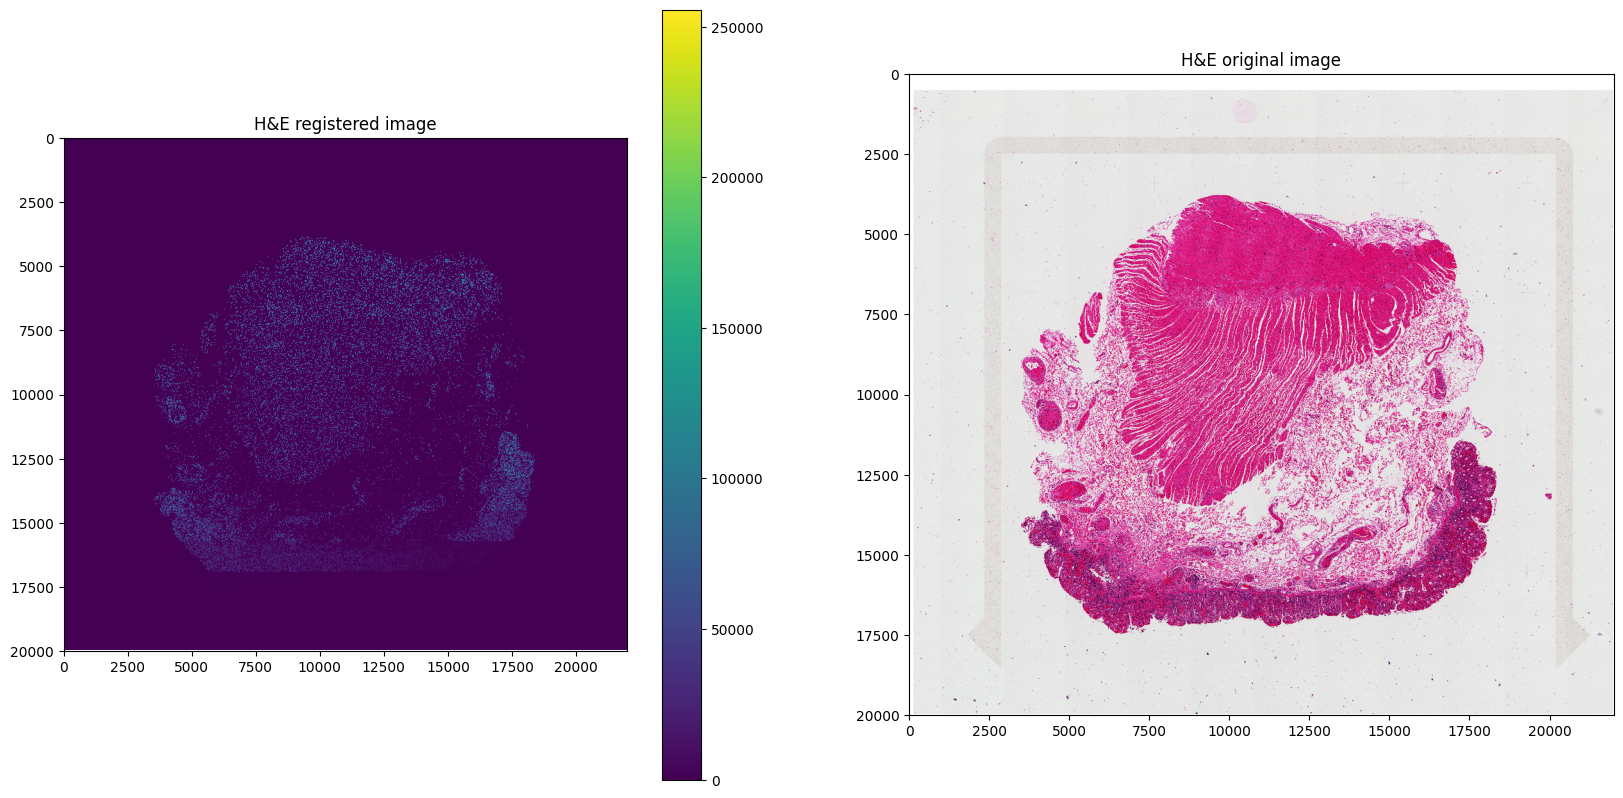

In [13]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes to easily index them

sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

## Target (Y) -  aggregated gene expression data for each cell

In [5]:
## Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
print(gene_name_list, len( gene_name_list))

['A2M' 'ACP5' 'ACTA2' 'ADAMTSL3' 'AFAP1L2' 'AHR' 'ALDH1B1' 'ANO1' 'ANXA1'
 'AQP1' 'AQP8' 'AREG' 'ASCL2' 'ATIC' 'AVIL' 'AXL' 'BANK1' 'BATF' 'BCAS1'
 'BMX' 'BNC2' 'BTNL9' 'C1QA' 'C1QC' 'C3' 'C7' 'CA1' 'CA2' 'CA4' 'CA7'
 'CADM1' 'CADPS' 'CALCB' 'CARD9' 'CAV1' 'CBLB' 'CCK' 'CCL1' 'CCL11'
 'CCL13' 'CCL19' 'CCL2' 'CCL20' 'CCL22' 'CCL23' 'CCL24' 'CCL3L1' 'CCL4'
 'CCL5' 'CCL7' 'CCL8' 'CCNB1' 'CCR1' 'CCR2' 'CCR3' 'CCR4' 'CCR5' 'CCR6'
 'CCR7' 'CCR8' 'CD163' 'CD163L1' 'CD19' 'CD1C' 'CD2' 'CD209' 'CD22'
 'CD247' 'CD27' 'CD300E' 'CD36' 'CD38' 'CD3D' 'CD3G' 'CD4' 'CD40LG' 'CD5'
 'CD55' 'CD6' 'CD68' 'CD69' 'CD7' 'CD79A' 'CD83' 'CD86' 'CD8A' 'CD8B'
 'CD9' 'CDC20' 'CDCA7' 'CDHR5' 'CDK1' 'CDK15' 'CDKN2B' 'CEACAM1' 'CEACAM7'
 'CELF2' 'CES1' 'CES2' 'CFTR' 'CHAT' 'CHGB' 'CHI3L1' 'CLC' 'CLCA4'
 'CLEC10A' 'CLEC9A' 'CMTM2' 'CNRIP1' 'COL14A1' 'COL4A2' 'COL6A3' 'CORO1A'
 'COX4I2' 'CRTAM' 'CSF1R' 'CSF3' 'CST7' 'CSTA' 'CTLA4' 'CXCL1' 'CXCL10'
 'CXCL11' 'CXCL12' 'CXCL13' 'CXCL2' 'CXCL3' 'CXCL5' 'CXCL6' 'CXCR1'
 'C

In [ ]:
# !pip install napari-spatialdata
# !pip install pyqt5


In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
from spatialdata import SpatialData

from napari_spatialdata import Interactive

In [6]:
sdata['anucleus']

AnnData object with n_obs × n_vars = 140368 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

In [7]:
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
display(x_count)

A2M  ACP5  ACTA2  ADAMTSL3  AFAP1L2  AHR  ALDH1B1  ANO1  ANXA1  AQP1  \
0         0     0      0         0        0    0        0     0      1     0   
1         0     0      0         0        0    0        0     0      0     0   
2         0     0      0         1        0    0        0     0      1     0   
3         0     0      3         0        0    0        0     0      0     0   
4         0     0      1         1        0    0        0     0      0     1   
...     ...   ...    ...       ...      ...  ...      ...   ...    ...   ...   
140363    2     0      0         0        0    0        0     0      0     0   
140364    0     0      0         0        0    0        0     0      0     0   
140365    0     0      1         0        0    0        0     0      0     0   
140366    0     0      0         0        1    0        0     0      0     0   
140367    0     0      0         0        0    0        0     0      0     0   

        ...  VCAN  VIL1  VIM  VPREB3  VWA5A  WFDC2  XBP1  XCL2  XCR1  ZEB2  
0       ...     0     0    0       0      0      0     0     0     0     0  
1       ...     0     0    0       0      0      0     0     0     0     0  
2       ...     0     0    0       0      0      0     0     0     0     0  
3       ...     0     0    0       0      0      0     0     0     0     0  
4       ...     0     0    0       0      0      0     0     0     0     0  
...     ...   ...   ...  ...     ...    ...    ...   ...   ...   ...   ...  
140363  ...     1     0    2       0      0      0     1     0     0     0  
140364  ...     0     2    0       0      0      0     1     0     0     0  
140365  ...     0     0    0       0      0      0     0     0     0     0  
140366  ...     0     0    0       0      0      0     0     0     0     0  
140367  ...     0     0    0       0      0      0     0     0     0     0  

[140368 rows x 460 columns]

In [18]:
x_norm = pd.DataFrame((sdata['anucleus'].X), columns=gene_name_list) # normalized data
display(x_norm)

A2M  ACP5     ACTA2  ADAMTSL3   AFAP1L2  AHR  ALDH1B1  ANO1  \
0       0.000000   0.0  0.000000  0.000000  0.000000  0.0      0.0   0.0   
1       0.000000   0.0  0.000000  0.000000  0.000000  0.0      0.0   0.0   
2       0.000000   0.0  0.000000  2.233592  0.000000  0.0      0.0   0.0   
3       0.000000   0.0  2.368131  0.000000  0.000000  0.0      0.0   0.0   
4       0.000000   0.0  1.185624  1.185624  0.000000  0.0      0.0   0.0   
...          ...   ...       ...       ...       ...  ...      ...   ...   
140363  1.578185   0.0  0.000000  0.000000  0.000000  0.0      0.0   0.0   
140364  0.000000   0.0  0.000000  0.000000  0.000000  0.0      0.0   0.0   
140365  0.000000   0.0  0.960462  0.000000  0.000000  0.0      0.0   0.0   
140366  0.000000   0.0  0.000000  0.000000  0.832344  0.0      0.0   0.0   
140367  0.000000   0.0  0.000000  0.000000  0.000000  0.0      0.0   0.0   

           ANXA1      AQP1  ...      VCAN      VIL1       VIM  VPREB3  VWA5A  \
0       2.233592  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
1       0.000000  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
2       2.233592  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
3       0.000000  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
4       0.000000  1.185624  ...  0.000000  0.000000  0.000000     0.0    0.0   
...          ...       ...  ...       ...       ...       ...     ...    ...   
140363  0.000000  0.000000  ...  1.072637  0.000000  1.578185     0.0    0.0   
140364  0.000000  0.000000  ...  0.000000  1.085454  0.000000     0.0    0.0   
140365  0.000000  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
140366  0.000000  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   
140367  0.000000  0.000000  ...  0.000000  0.000000  0.000000     0.0    0.0   

        WFDC2      XBP1  XCL2  XCR1  ZEB2  
0         0.0  0.000000   0.0   0.0   0.0  
1         0.0  0.000000   0.0   0.0   0.0  
2         0.0  0.000000   0.0   0.0   0.0  
3         0.0  0.000000   0.0   0.0   0.0  
4         0.0  0.000000   0.0   0.0   0.0  
...       ...       ...   ...   ...   ...  
140363    0.0  1.072637   0.0   0.0   0.0  
140364    0.0  0.683295   0.0   0.0   0.0  
140365    0.0  0.000000   0.0   0.0   0.0  
140366    0.0  0.000000   0.0   0.0   0.0  
140367    0.0  0.000000   0.0   0.0   0.0  

[140368 rows x 460 columns]

In [41]:
## Selecting training cells
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()
cell_id_example = list(set(cell_id_example).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))

## Get y from the anucleus data
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]

In [22]:
# sdata['cell_id-group'].obs['cell_id']
sdata['cell_id-group'].obs['group'].unique()
sdata['cell_id-group']
sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']


cell_id  group
5             6  train
11           12  train
13           14  train
22           23  train
36           37  train
...         ...    ...
183906   224288  train
183910   224292  train
183915   224297  train
183919   224301  train
183943   224325  train

[140368 rows x 2 columns]

In [17]:
# len(set(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test']['cell_id'].to_numpy()))
sdata,sdata['anucleus']

(SpatialData object, with associated Zarr store: C:\DATA\Crunch\data\UC1_I.zarr
 ├── Images
 │     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 22000)
 │     └── 'HE_original': DataArray[cyx] (3, 20000, 22000)
 └── Tables
       ├── 'anucleus': AnnData (202534, 460)
       └── 'cell_id-group': AnnData (234356, 0)
 with coordinate systems:
     ▸ 'global', with elements:
         HE_nuc_original (Images), HE_original (Images),
 AnnData object with n_obs × n_vars = 202534 × 460
     obs: 'cell_id'
     var: 'gene_symbols'
     obsm: 'spatial'
     layers: 'counts')

In [42]:
y = pd.DataFrame(ground_truth_example, columns= gene_name_list, index = cell_id_example)
y

A2M  ACP5  ACTA2  ADAMTSL3  AFAP1L2  AHR  ALDH1B1  ANO1  ANXA1  AQP1  \
6         0     0      0         0        0    0        0     0      1     0   
12        0     0      0         0        0    0        0     0      0     0   
14        0     0      0         1        0    0        0     0      1     0   
23        0     0      3         0        0    0        0     0      0     0   
37        0     0      1         1        0    0        0     0      0     1   
...     ...   ...    ...       ...      ...  ...      ...   ...    ...   ...   
224288    2     0      0         0        0    0        0     0      0     0   
224292    0     0      0         0        0    0        0     0      0     0   
224297    0     0      1         0        0    0        0     0      0     0   
224301    0     0      0         0        1    0        0     0      0     0   
224325    0     0      0         0        0    0        0     0      0     0   

        ...  VCAN  VIL1  VIM  VPREB3  VWA5A  WFDC2  XBP1  XCL2  XCR1  ZEB2  
6       ...     0     0    0       0      0      0     0     0     0     0  
12      ...     0     0    0       0      0      0     0     0     0     0  
14      ...     0     0    0       0      0      0     0     0     0     0  
23      ...     0     0    0       0      0      0     0     0     0     0  
37      ...     0     0    0       0      0      0     0     0     0     0  
...     ...   ...   ...  ...     ...    ...    ...   ...   ...   ...   ...  
224288  ...     1     0    2       0      0      0     1     0     0     0  
224292  ...     0     2    0       0      0      0     1     0     0     0  
224297  ...     0     0    0       0      0      0     0     0     0     0  
224301  ...     0     0    0       0      0      0     0     0     0     0  
224325  ...     0     0    0       0      0      0     0     0     0     0  

[140368 rows x 460 columns]

In [46]:
ground_truth_example
set(sdata['anucleus'].obs['cell_id'])

{6,
 12,
 14,
 23,
 37,
 39,
 43,
 67,
 75,
 76,
 80,
 81,
 82,
 88,
 104,
 107,
 109,
 115,
 130,
 133,
 140,
 142,
 149,
 158,
 200,
 201,
 213,
 253,
 323,
 358,
 362,
 370,
 375,
 377,
 381,
 404,
 1874,
 2969,
 2970,
 2971,
 2972,
 2973,
 2974,
 2975,
 2976,
 2977,
 2978,
 2979,
 2980,
 2981,
 2982,
 2983,
 2984,
 2985,
 2986,
 2987,
 2988,
 2989,
 2990,
 2991,
 2992,
 2993,
 2994,
 2995,
 2996,
 2997,
 2998,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3007,
 3008,
 3009,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3018,
 3019,
 3020,
 3021,
 3022,
 3023,
 3025,
 3028,
 3029,
 3030,
 3031,
 3032,
 3033,
 3034,
 3035,
 3036,
 3037,
 3038,
 3039,
 3040,
 3041,
 3042,
 3043,
 3044,
 3045,
 3046,
 3047,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3055,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3062,
 3063,
 3064,
 3065,
 3066,
 3067,
 3068,
 3069,
 3070,
 3071,
 3072,
 3073,
 3074,
 3075,
 3076,
 3077,
 3078,
 3079,
 3080,
 3081,
 3082,
 3083,
 3084,
 3085,
 3086,
 

In [43]:
sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']


cell_id  group
5             6  train
11           12  train
13           14  train
22           23  train
36           37  train
...         ...    ...
183906   224288  train
183910   224292  train
183915   224297  train
183919   224301  train
183943   224325  train

[140368 rows x 2 columns]

# Cropping img to smaller chunks

In [ ]:
import numpy as np
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
import os

def save_cropped_cells(sdata, crop_size=128, out_dir='image_crop'):
    """
    Function to save cropped cell images from the original intensity image.

    Parameters:
    sdata: SpatialData object containing the image data.
    crop_size: Size of the square crop around each cell's centroid.
    out_dir: Directory where the cropped images will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Get regions from the nucleus image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    # Get the original intensity image
    intensity_image = sdata['HE_original'].to_numpy()

    # Half of the crop size to calculate boundaries
    half_crop = crop_size // 2

    crop_list = []

    # Loop through each region and extract the crop
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])

        # Calculate the crop boundaries
        minr, maxr = y_center - half_crop, y_center + half_crop
        minc, maxc = x_center - half_crop, x_center + half_crop

        # Ensure boundaries are within the image dimensions
        pad_top = max(0, -minr)
        minr = max(0, minr)

        pad_bottom = max(0, maxr - intensity_image.shape[1])
        maxr = min(maxr, intensity_image.shape[1])

        pad_left = max(0, -minc)
        minc = max(0, minc)

        pad_right = max(0, maxc - intensity_image.shape[2])
        maxc = min(maxc, intensity_image.shape[2])

        # Crop and pad the image if needed
        if pad_top + pad_bottom + pad_left + pad_right > 0:
            crop = np.pad(intensity_image[:, minr:maxr, minc:maxc],
                          ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                          mode='constant', constant_values=0)
        else:
            crop = intensity_image[:, minr:maxr, minc:maxc]


        crop_list.append(crop)
        # Save the crop as a TIFF file
        tifffile.imwrite(f"{out_dir}/{cell_id}.tif", crop.astype('uint8'), metadata={'axes': 'CYX'})

    return crop_list

In [12]:
crop_list = save_cropped_cells(sdata)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93686/93686 [08:32<00:00, 182.75it/s]


# Visualization of X and y

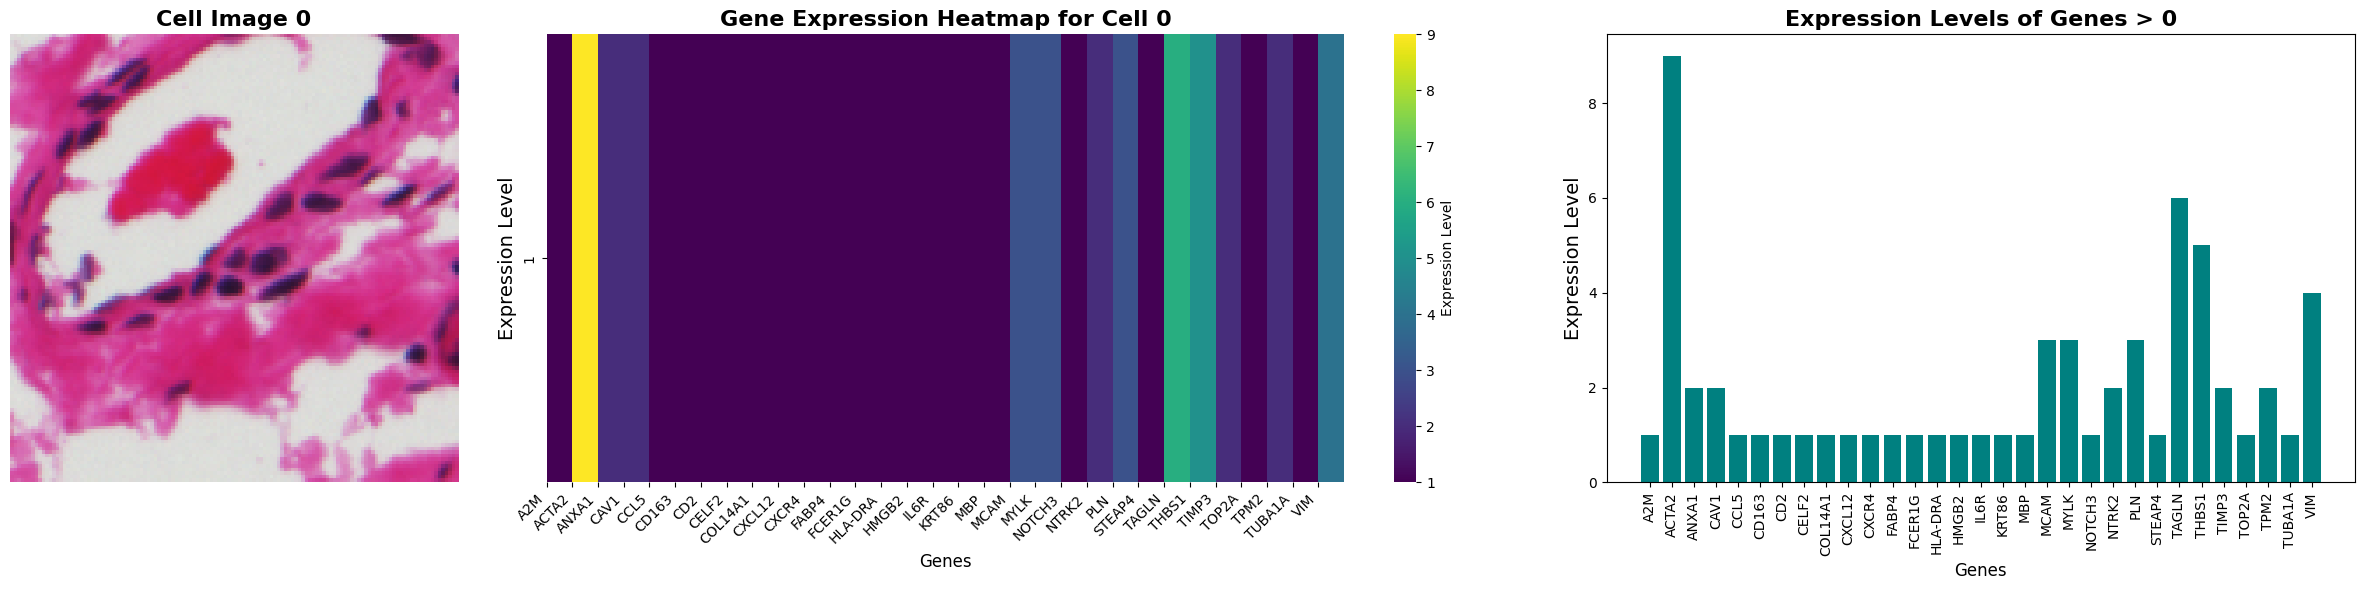

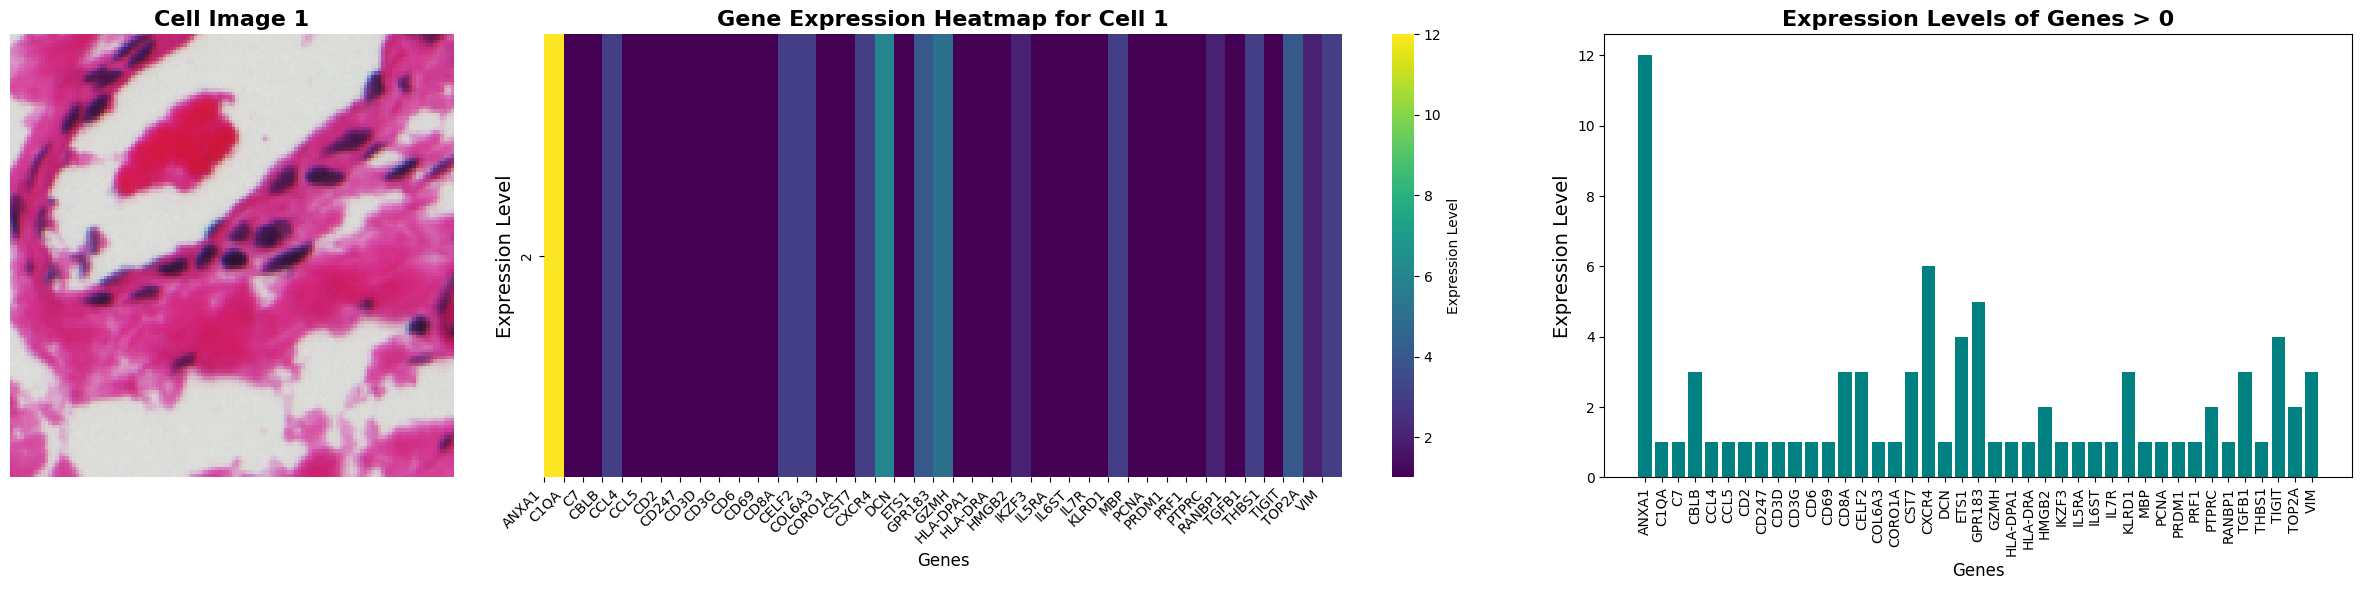

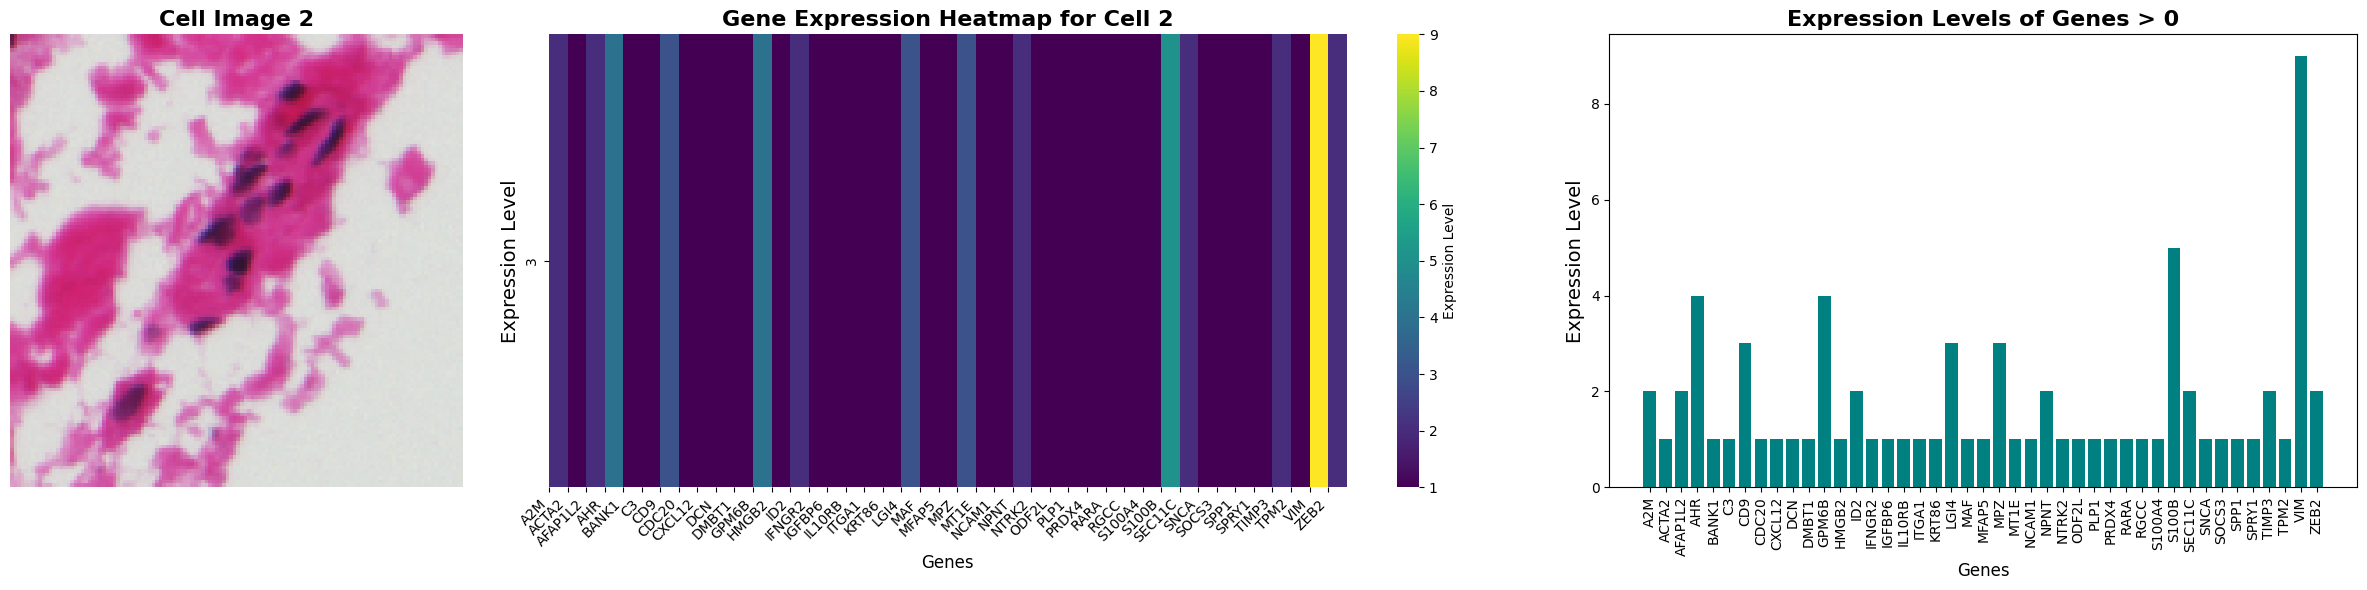

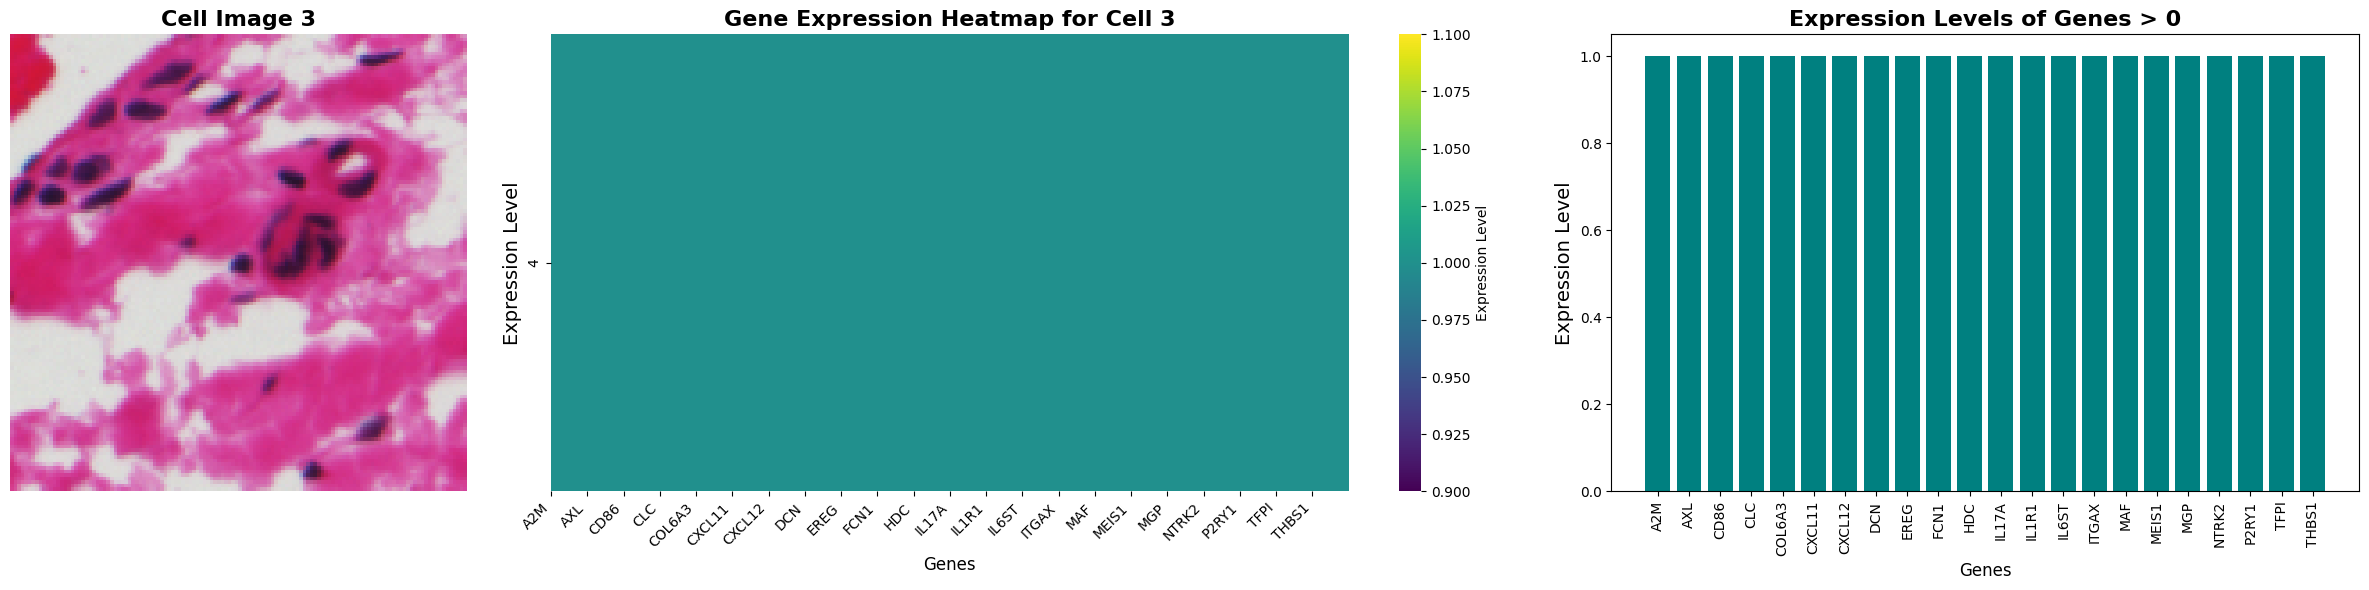

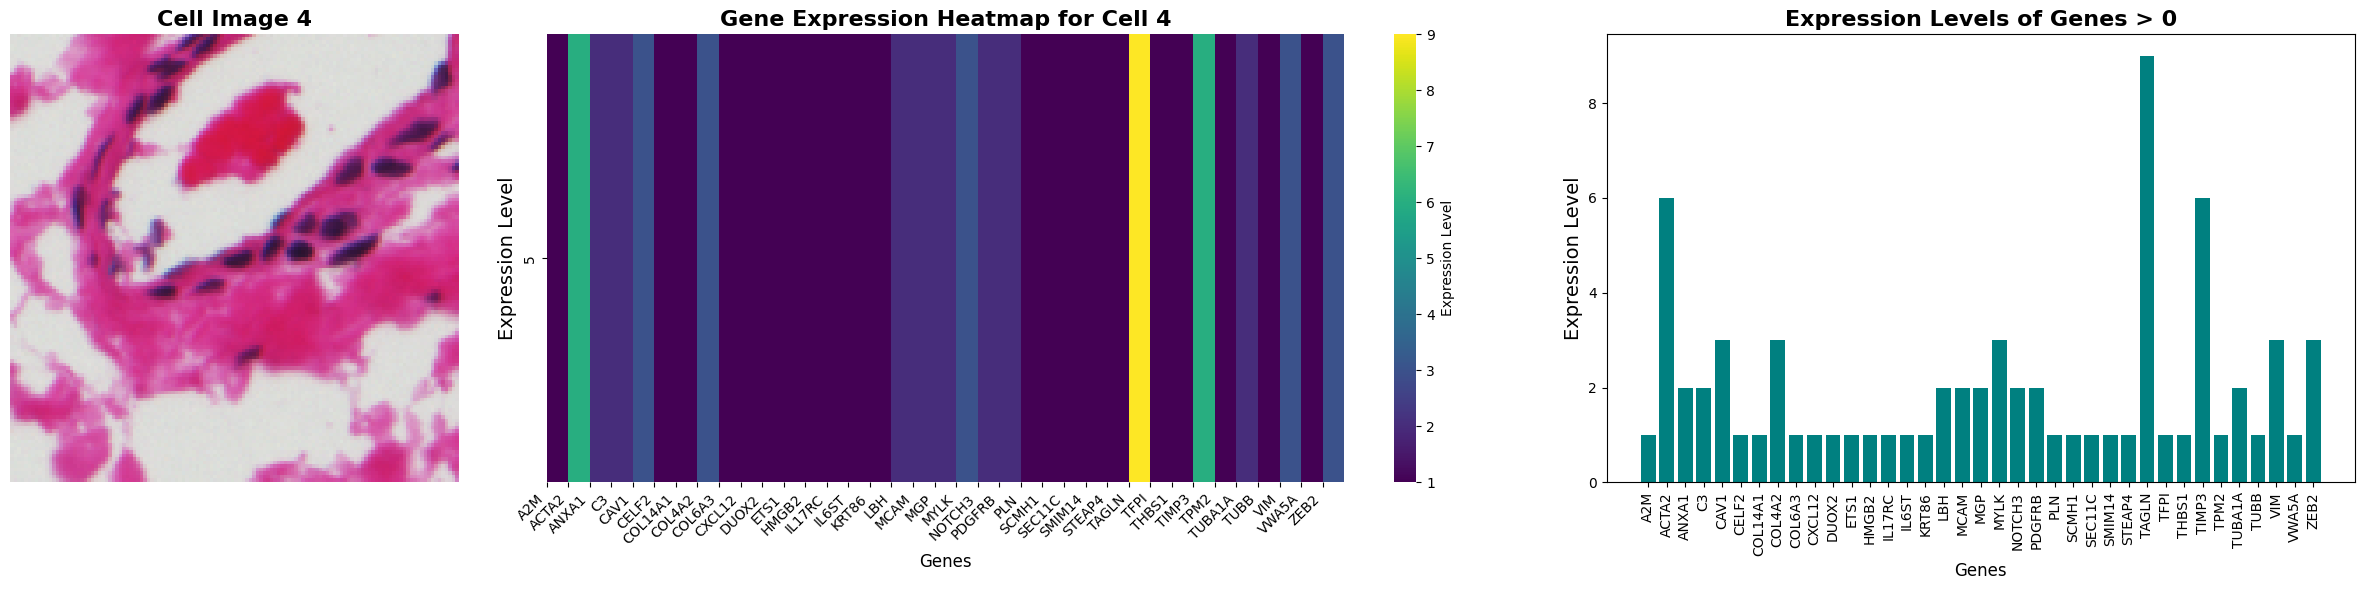

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop over the first four cells
for cell_id in range(5):
    # Create a figure with three subplots (image, heatmap, and bar chart)
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 1.5]}, figsize=(24, 6))

    # First plot: Image of the cell on the left
    ax[0].imshow(crop_list[cell_id].transpose((1, 2, 0)))
    ax[0].set_title(f'Cell Image {cell_id}', fontsize=16, fontweight='bold')
    ax[0].axis('off')  # Hide axes for image clarity

    # Filter the gene expression data to include only genes with expression > 0
    gene_expression_data = y.iloc[cell_id]
    filtered_data = gene_expression_data[gene_expression_data > 0]
    heatmap_data = pd.DataFrame(filtered_data).transpose()

    # Second plot: Gene Expression Heatmap with filtered genes
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='viridis',  # Color map for expression levels
        fmt=".2f",
        ax=ax[1],
        cbar_kws={'label': 'Expression Level'}  # Color bar with label
    )

    # Titles and labels with enhanced readability for heatmap
    ax[1].set_title(f'Gene Expression Heatmap for Cell {cell_id}', fontsize=16, fontweight='bold')
    ax[1].set_xlabel('Genes', fontsize=12)
    ax[1].set_ylabel('Expression Level', fontsize=14)
    ax[1].set_xticks(range(len(filtered_data.index)))
    ax[1].set_xticklabels(filtered_data.index, rotation=45, ha='right', fontsize=10)

    # Third plot: Bar Chart for gene expression levels
    ax[2].bar(filtered_data.index, filtered_data.values, color='teal')
    ax[2].set_title("Expression Levels of Genes > 0", fontsize=16, fontweight='bold')
    ax[2].set_xlabel("Genes", fontsize=12)
    ax[2].set_ylabel("Expression Level", fontsize=14)
    ax[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [ ]:
def log1p_normalization(arr):
    # max_vals = arr.max(axis=1, keepdims=True)
    return np.log1p((arr/np.sum(arr, axis=1)) * 100)

def scoring(model_output: pd.DataFrame, ground_truth: pd.DataFrame):
    mse = np.sum((np.square(model_output - ground_truth)).mean(axis=1))

    return mse

#TEST

In [47]:
import scprep as scp
a=scp.normalize.library_size_normalize([[1,2,3],[5,6,7]])
a

array([[1666.66666667, 3333.33333333, 5000.        ],
       [2777.77777778, 3333.33333333, 3888.88888889]])

In [3]:
import os
e='E:/projects/Gene_expression'
cnt_dir = f'{e}/data/her2st/data/ST-cnts'
img_dir = f'{e}/data/her2st/data/ST-imgs'
pos_dir = f'{e}/data/her2st/data/ST-spotfiles'
lbl_dir = f'{e}/data/her2st/data/ST-pat/lbl'
def get_cnt( name):
        path = cnt_dir + '/' + name + '.tsv'
        df = pd.read_csv(path, sep='\t', index_col=0)
        return df

def get_pos(name):
    path = pos_dir + '/' + name + '_selection.tsv'
    df = pd.read_csv(path, sep='\t')
    x = df['x'].values
    y = df['y'].values
    x = np.around(x).astype(int)
    y = np.around(y).astype(int)
    id = []
    for i in range(len(x)):
        id.append(str(x[i]) + 'x' + str(y[i]))
    df['id'] = id
    return df
def get_meta( name, gene_list=None):
        cnt = get_cnt(name)
        pos = get_pos(name)
        meta = cnt.join((pos.set_index('id')))
        return meta
e='E:/projects/Gene_expression'

names = os.listdir(cnt_dir)
names.sort()
names = [i[:2] for i in names][:2]
meta_dict = {i: get_meta(i) for i in names}
gene_list = list(np.load(f'{e}/data/her_hvg_cut_1000.npy', allow_pickle=True))

In [74]:
center_dict = {i: np.floor(m[['pixel_x', 'pixel_y']].values).astype(int) for i, m in
                            meta_dict.items()}
loc_dict = {i: m[['x', 'y']].values for i, m in meta_dict.items()}

In [84]:
c_sort=center_dict['A1']
c_sort.sort()
len(c_sort),len(loc_dict['A1'])


346

In [5]:
meta_dict.values()

dict_values([       FO538757.1  SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  \
10x13           0       6      1       0        0      0     2      0     0   
10x14           0       6      3       1        0      0     3      0     1   
10x15           1       1      0       0        0      0     6      1     2   
10x16           0       6      1       0        0      0     3      0     0   
10x17           0       1      2       0        0      0     4      0     1   
...           ...     ...    ...     ...      ...    ...   ...    ...   ...   
9x23            1       1      0       0        0      0     3      0     0   
9x24            0       1      5       1        0      0     1      1     0   
9x25            0       3      1       0        0      0     8      0     1   
9x26            0       2      2       0        0      0     4      0     0   
9x27            0       2      1       0        0      0     0      0     0   

       RNF223  ...  UTY  KDM5D  EIF1AY

In [7]:
lengths = [len(i) for i in meta_dict.values()]
lengths,np.cumsum(lengths)

([346, 325], array([346, 671]))

In [45]:
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
x_count


A2M  ACP5  ACTA2  ADAMTSL3  AFAP1L2  AHR  ALDH1B1  ANO1  ANXA1  AQP1  \
0         0     0      0         0        0    0        0     0      0     0   
1         0     0      0         0        0    0        0     0      0     0   
2         0     0      0         0        0    0        0     0      0     0   
3         0     0      0         0        0    0        0     0      0     0   
4         1     0      0         0        0    0        0     0      0     0   
...     ...   ...    ...       ...      ...  ...      ...   ...    ...   ...   
202529    1     0      0         0        0    0        0     0      0     2   
202530    4     0      2         0        0    0        0     1      1     0   
202531    0     0      0         0        0    0        0     0      5     0   
202532    0     0      0         0        0    0        0     2      0     0   
202533    1     0      0         0        0    0        0     0      2     0   

        ...  VCAN  VIL1  VIM  VPREB3  VWA5A  WFDC2  XBP1  XCL2  XCR1  ZEB2  
0       ...     0     0    0       0      0      0     0     0     0     0  
1       ...     0     0    1       0      0      0     0     0     0     1  
2       ...     0     0    0       0      0      0     0     0     0     0  
3       ...     0     0    5       0      0      0     2     0     0     0  
4       ...     0     0    0       0      1      0     0     0     0     0  
...     ...   ...   ...  ...     ...    ...    ...   ...   ...   ...   ...  
202529  ...     0     0    1       0      0      0     0     0     0     0  
202530  ...     0     0    6       0      0      0     0     0     0     1  
202531  ...     0     0    1       0      0      0     0     0     0     0  
202532  ...     0     0    1       0      0      0     0     0     0     0  
202533  ...     0     0    0       0      0      0     0     0     0     0  

[202534 rows x 460 columns]

In [58]:
exp_dict = {
                i: sc.pp.scale(scp.transform.log(scp.normalize.library_size_normalize(m[gene_list].values))) for
                i, m in meta_dict.items()}

In [80]:
x_count['A2M']

0         0
1         0
2         0
3         0
4         1
         ..
202529    1
202530    4
202531    0
202532    0
202533    1
Name: A2M, Length: 202534, dtype: int64

In [106]:
x_norm.values[202532].sum()
# x_norm['A2M'].values.sum()

31.184797

In [89]:
test_log=scp.transform.log(scp.normalize.library_size_normalize(x_count[gene_name_list].values))

In [ ]:
list(gene_name_list)
# gene_list
exp_dict
# list_test= list( list(gene_name_list))
# list_test.index('ANXA1')
# x_count.items()

In [4]:
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

In [140]:
d={}
d['1']=3
d

{'1': 3}

In [ ]:
for i, m in meta_dict.items():
    print(len(m[['pixel_x', 'pixel_y']].values))
    break
for i, m in meta_dict.items():
    print(len(m[['x', 'y']].values))
    break

346


In [23]:

# regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())
center_list=[]
cell_id_list=[]
for props in tqdm(regions):
    cell_id= props.label
    centroid = props.centroid
    center_list.append([int(centroid[0]), int(centroid[1])])
    cell_id_list.append(int(cell_id))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234356/234356 [00:16<00:00, 14453.20it/s]


In [ ]:
for i in range (20):
    print(center_list[i],cell_id_list[i])

[16936, 14070] 1
[16935, 14152] 3
[16943, 14061] 4
[16939, 14111] 5
[16941, 14039] 6
[16949, 14043] 7
[16933, 14063] 8
[16930, 14629] 9
[16929, 14886] 10
[16936, 14081] 11
[16975, 13927] 14
[17009, 13783] 15
[16956, 13575] 16
[16947, 13527] 17
[16937, 13799] 18
[16958, 13581] 19
[16948, 13830] 20
[17016, 13780] 21
[16930, 13115] 22
[16960, 13734] 23


In [ ]:
ar_test=sdata['anucleus'].layers['counts']

In [ ]:
ar_sum=ar_test[0] + ar_test[1]
ar_sum[ar_sum!=0], len(ar_sum[ar_sum!=0])

(array([1, 1, 1, 4, 3, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1,
        2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 5, 2, 3, 1,
        1, 1, 1, 1, 1, 1, 1], dtype=int64),
 51,
 460)

In [ ]:
ar_test[0][ar_test[0]!=0], len(ar_test[0][ar_test[0]!=0]),ar_test[1][ar_test[1]!=0], len(ar_test[1][ar_test[1]!=0])

(array([1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        5, 1, 1, 1, 1], dtype=int64),
 27,
 array([1, 1, 4, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 2, 2, 1,
        1, 1, 1, 1], dtype=int64),
 26)

In [ ]:
c_sort
len(center_list)

234356

In [ ]:
canvas_size = 10000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 128
half_square = square_size // 2

for x, y in c_sort:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(21, 21))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*c_sort), color='red', marker='o',s=0.1)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

In [95]:
validation_id_list=list(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'validation' ]['cell_id'])
test_id_list=list(sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test' ]['cell_id'])


In [96]:
vt_center_list=[]
vt_cell_id_list=[]
vt_center_list=[]
t_cell_id_list=[]
t_center_list=[]
t_cell_id_list=[]
for props in tqdm(regions):
    cell_id= props.label
    centroid = props.centroid
    if cell_id in validation_id_list or cell_id in test_id_list:
        vt_center_list.append([int(centroid[0]), int(centroid[1])])
        vt_cell_id_list.append(int(cell_id))
    else:
        t_center_list.append([int(centroid[0]), int(centroid[1])])
        t_cell_id_list.append(int(cell_id))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234356/234356 [01:51<00:00, 2093.27it/s]


In [101]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 64
half_square = square_size // 2

for x, y in vt_center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(200, 200))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*vt_center_list), color='red', marker='o',s=0.40)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [ ]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 64
half_square = square_size // 2

for x, y in t_center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(190, 190))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*t_center_list), color='red', marker='o',s=0.30)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()
del canvas

KeyboardInterrupt: 

In [ ]:
canvas_size = 20000
canvas = np.zeros((canvas_size, canvas_size))

# Mark each square centered at the coordinates
square_size = 128
half_square = square_size // 2

for x, y in center_list:
    # Calculate the bounding box of the square
    x_start = max(x - half_square, 0)
    x_end = min(x + half_square, canvas_size)
    y_start = max(y - half_square, 0)
    y_end = min(y + half_square, canvas_size)
    
    # Set the square's region to a fixed intensity value
    canvas[y_start:y_start + 1, x_start:x_end] = 0.5  # Top edge
    canvas[y_end - 1:y_end, x_start:x_end] = 0.5      # Bottom edge
    canvas[y_start:y_end, x_start:x_start + 1] = 0.5  # Left edge
    canvas[y_start:y_end, x_end - 1:x_end] = 0.5      # Right edge
    
    # Mark vertices
    vertices = [(y_start, x_start), (y_start, x_end - 1),
                (y_end - 1, x_start), (y_end - 1, x_end - 1)]
    for vy, vx in c_sort:
        canvas[vy, vx] = 0.5


# Plotting the result
plt.figure(figsize=(20, 20))
plt.imshow(canvas, cmap='gray')
plt.scatter(*zip(*center_list), color='red', marker='o',s=0.10)  # Overlay the points in red for contrast
plt.title('Single Channel Plot with Centered Squares')
plt.axis('off')
plt.show()

In [8]:
len(sdata['anucleus'].layers['counts'])

80037